#### Importing required packages

In [361]:
# Core
import os
import glob
import re
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from scipy.stats import zscore


# Time series
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

# ML
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor


# DL
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D
from tensorflow.keras.layers import LSTM, Dense, Dropout, LayerNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Attention, Input
from tensorflow.keras.models import Model

# Utils
import warnings
warnings.filterwarnings("ignore")


In [362]:
input_dir = "../data/"


In [363]:
# List to store dataframes
all_coins = []
# Iterate through all csv files in the directory
files = glob.glob(os.path.join(input_dir, "coin_*.csv"))
for filepath in files:
    try:
        # Read the file
        df_temp = pd.read_csv(filepath)
        # Extract coin name from filename if not in columns, or strictly use filename
        coin_name = os.path.basename(filepath).split('_')[1].split('.')[0]
        # Ensure we have a column for the coin name to distinguish after merging
        df_temp['Coin_Name'] = coin_name
        all_coins.append(df_temp)
    except Exception as e:
        print(f"Error reading {filepath}: {e}")


In [364]:
dir = "D:/All_Projects/crypto-forecasting-project/reports/"


In [365]:
def save_plot_from_title(fig=None, dpi=300):
    """
    Saves the current matplotlib figure using its title as filename.
    """
    if fig is None:
        fig = plt.gcf()
        
    title = plt.gca().get_title()
    
    if not title:
        raise ValueError("Plot must have a title to save automatically.")
    
    # Clean title for filename
    filename = re.sub(r'[^a-zA-Z0-9_-]', '_', title)
    filepath = os.path.join(dir, f"{filename}.png")
    fig.savefig(filepath, dpi=dpi, bbox_inches="tight")
    print(f"Saved plot: {filepath}")


#### Load the Datasets
Here, I used BitCoin dataset

In [366]:
# Concatenate all into one master dataframe
# df = pd.concat(all_coins, axis=0, ignore_index=True)
df = pd.read_csv("../data/coin_Bitcoin.csv")


In [367]:
print(f"Total Rows: {df.shape[0]}")
print(f"Total Columns: {df.shape[1]}")
# print(f"Unique Coins: {df['Coin_Name'].nunique()}")


Total Rows: 2991
Total Columns: 10


## Data Understanding & EDA Requirements

In [368]:
df.dtypes


SNo            int64
Name          object
Symbol        object
Date          object
High         float64
Low          float64
Open         float64
Close        float64
Volume       float64
Marketcap    float64
dtype: object

In [369]:
# Convert Date to datetime object
df['Date'] = pd.to_datetime(df['Date'])
df.dtypes


SNo                   int64
Name                 object
Symbol               object
Date         datetime64[ns]
High                float64
Low                 float64
Open                float64
Close               float64
Volume              float64
Marketcap           float64
dtype: object

In [370]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2991 entries, 0 to 2990
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   SNo        2991 non-null   int64         
 1   Name       2991 non-null   object        
 2   Symbol     2991 non-null   object        
 3   Date       2991 non-null   datetime64[ns]
 4   High       2991 non-null   float64       
 5   Low        2991 non-null   float64       
 6   Open       2991 non-null   float64       
 7   Close      2991 non-null   float64       
 8   Volume     2991 non-null   float64       
 9   Marketcap  2991 non-null   float64       
dtypes: datetime64[ns](1), float64(6), int64(1), object(2)
memory usage: 233.8+ KB


### Plot for Close Price history

Saved plot: D:/All_Projects/crypto-forecasting-project/reports/Bitcoin_Close_Price.png


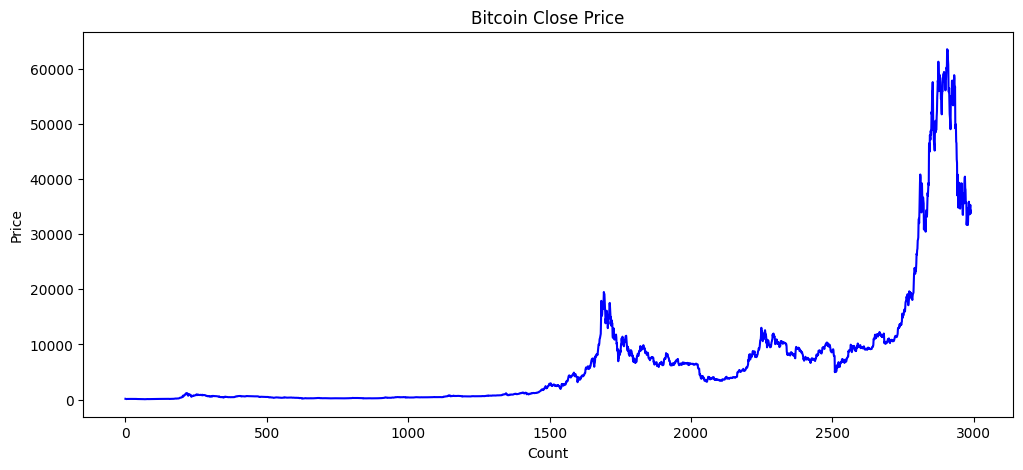

In [371]:
plt.figure(figsize=(12,5))
plt.plot(df['Close'], color='blue')
plt.title("Bitcoin Close Price")
plt.xlabel("Count")
plt.ylabel("Price")
save_plot_from_title()
plt.show()


#### Identifying Trend

In [372]:
df['MA_7']  = df['Close'].rolling(window=7).mean()
df['MA_15'] = df['Close'].rolling(window=15).mean()
df['MA_30'] = df['Close'].rolling(window=30).mean()
df.head(40)


,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap,MA_7,MA_15,MA_30
0,1,Bitcoin,BTC,2013-04-29 23:59:59,147.488007,134.000000,134.444000,144.539993,0.0,1.603769e+09,NaN,NaN,NaN
1,2,Bitcoin,BTC,2013-04-30 23:59:59,146.929993,134.050003,144.000000,139.000000,0.0,1.542813e+09,NaN,NaN,NaN
2,3,Bitcoin,BTC,2013-05-01 23:59:59,139.889999,107.720001,139.000000,116.989998,0.0,1.298955e+09,NaN,NaN,NaN
3,4,Bitcoin,BTC,2013-05-02 23:59:59,125.599998,92.281898,116.379997,105.209999,0.0,1.168517e+09,NaN,NaN,NaN
4,5,Bitcoin,BTC,2013-05-03 23:59:59,108.127998,79.099998,106.250000,97.750000,0.0,1.085995e+09,NaN,NaN,NaN
5,6,Bitcoin,BTC,2013-05-04 23:59:59,115.000000,92.500000,98.099998,112.500000,0.0,1.250317e+09,NaN,NaN,NaN
6,7,Bitcoin,BTC,2013-05-05 23:59:59,118.800003,107.142998,112.900002,115.910004,0.0,1.288693e+09,118.842856,NaN,NaN
7,8,Bitcoin,BTC,2013-05-06 23:59:59,124.663002,106.639999,115.980003,112.300003,0.0,1.249023e+09,114.237143,NaN,NaN
8,9,Bitcoin,BTC,2013-05-07 23:59:59,113.444000,97.699997,112.250000,111.500000,0.0,1.240594e+09,110.308572,NaN,NaN
9,10,Bitcoin,BTC,2013-05-08 23:59:59,115.779999,109.599998,109.599998,113.566002,0.0,1.264049e+09,109.819430,NaN,NaN


Saved plot: D:/All_Projects/crypto-forecasting-project/reports/Trend_Identification_using_Moving_Averages.png


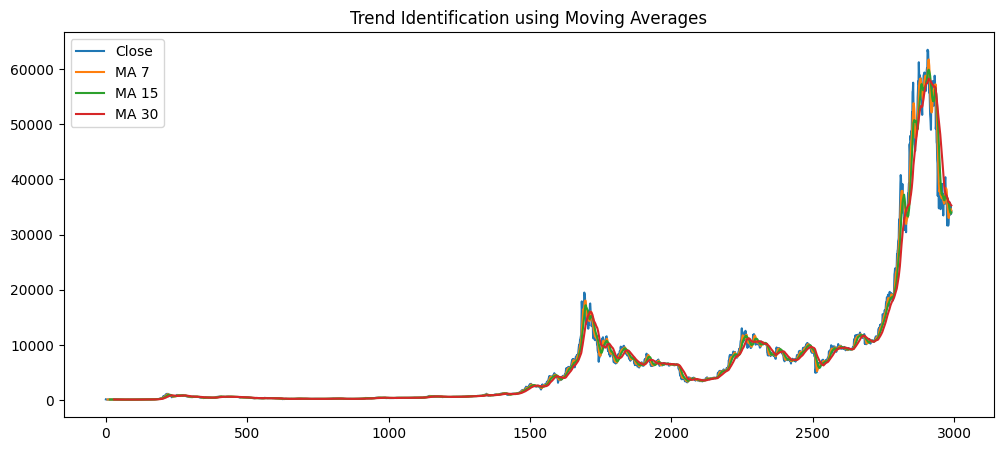

In [373]:
plt.figure(figsize=(12,5))
plt.plot(df['Close'], label='Close')
plt.plot(df['MA_7'], label='MA 7')
plt.plot(df['MA_15'], label='MA 15')
plt.plot(df['MA_30'], label='MA 30')
plt.legend()
plt.title("Trend Identification using Moving Averages")
save_plot_from_title()
plt.show()


#### Seasonality identification

Saved plot: D:/All_Projects/crypto-forecasting-project/reports/STL_Decomposition_of_Bitcoin_Close_Price.png


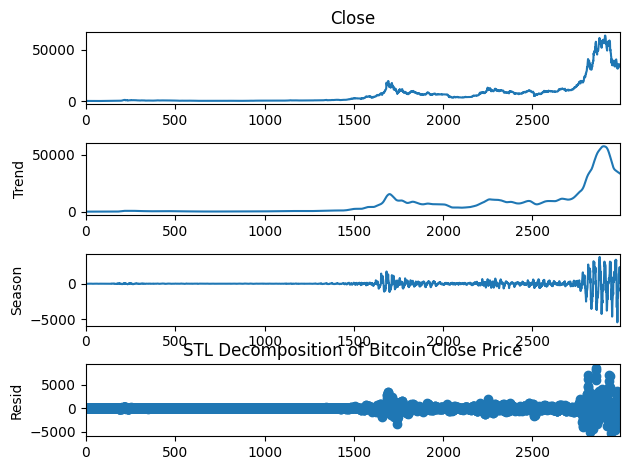

In [374]:
stl = STL(df['Close'], period=30)  # weekly seasonality
result = stl.fit()
df['Trend'] = result.trend
df['Seasonal'] = result.seasonal
df['Residual'] = result.resid
result.plot()
plt.title("STL Decomposition of Bitcoin Close Price")
save_plot_from_title()
plt.show()


Saved plot: D:/All_Projects/crypto-forecasting-project/reports/STL_Decomposition_with_Weekly_Seasonality.png


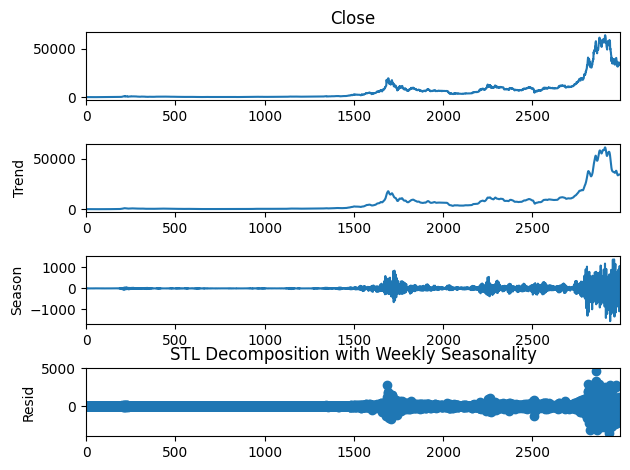

In [375]:
stl = STL(df['Close'], period=7)  # weekly seasonality
result = stl.fit()
df['Trend'] = result.trend
df['Seasonal'] = result.seasonal
df['Residual'] = result.resid
result.plot()
plt.title("STL Decomposition with Weekly Seasonality")
save_plot_from_title()
plt.show()


#### Volatility Identification

In [376]:
## Log return
df['log_return'] = np.log(df['Close'] / df['Close'].shift(1))


In [377]:
## Roling volatility
df['volatility_7']  = df['log_return'].rolling(7).std()
df['volatility_15'] = df['log_return'].rolling(15).std()
df['volatility_30'] = df['log_return'].rolling(30).std()


Saved plot: D:/All_Projects/crypto-forecasting-project/reports/Rolling_Volatility__Crypto_.png


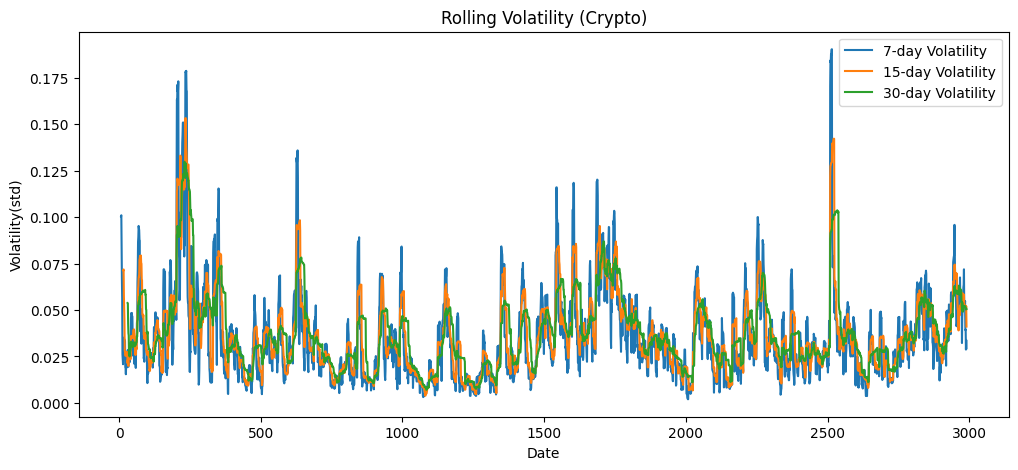

In [378]:
plt.figure(figsize=(12,5))
plt.plot(df['volatility_7'], label='7-day Volatility')
plt.plot(df['volatility_15'], label='15-day Volatility')
plt.plot(df['volatility_30'], label='30-day Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility(std)')
plt.legend()
plt.title("Rolling Volatility (Crypto)")
save_plot_from_title()
plt.show()


In [379]:
## Volatility Regimes
vol_threshold = df['volatility_30'].quantile(0.75)

df['volatility_regime_30'] = np.where(df['volatility_30'] > vol_threshold,'High Volatility','Low Volatility')


Saved plot: D:/All_Projects/crypto-forecasting-project/reports/Volatility__30-day_Rolling_Std_.png


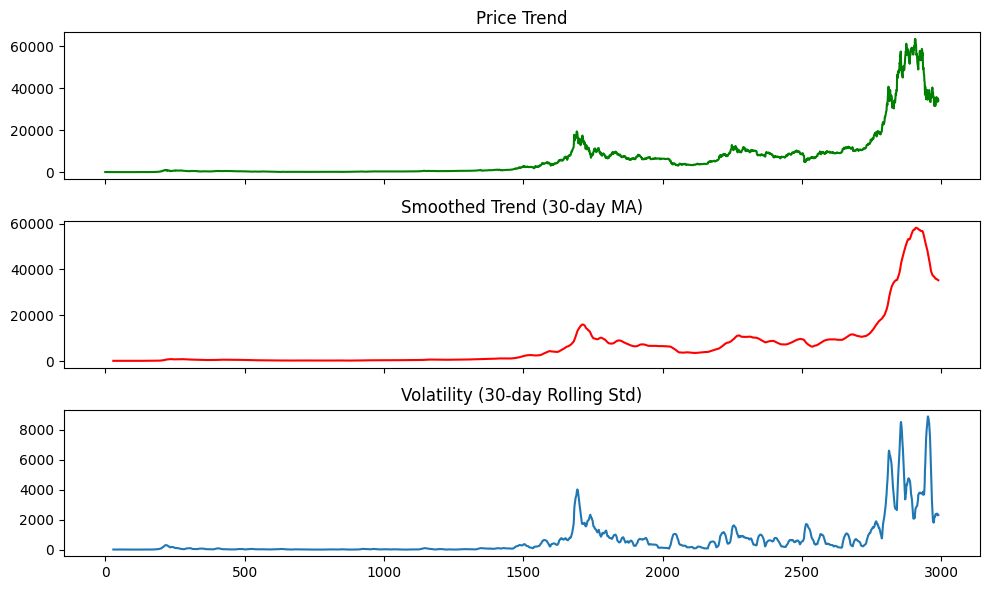

In [380]:
fig, axes = plt.subplots(3, 1, figsize=(10,6), sharex=True)
axes[0].plot(df['Close'], color = 'green')
axes[0].set_title('Price Trend')
axes[1].plot(df['Close'].rolling(30).mean(), color = 'red')
axes[1].set_title('Smoothed Trend (30-day MA)')
axes[2].plot(df['Close'].rolling(30).std())
axes[2].set_title('Volatility (30-day Rolling Std)')
plt.tight_layout()
save_plot_from_title()
plt.show()


Saved plot: D:/All_Projects/crypto-forecasting-project/reports/Volatility_Regimes_Count.png


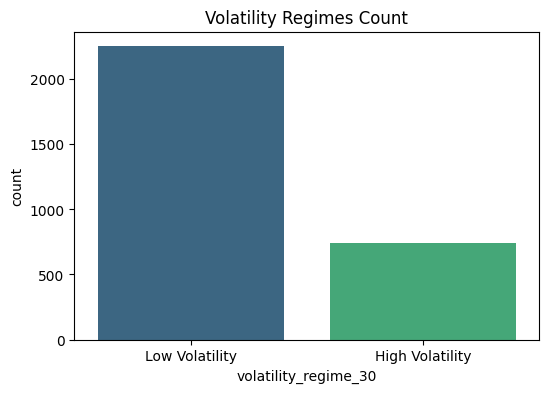

In [381]:
plt.figure(figsize=(6,4))
sns.countplot(x = "volatility_regime_30", data = df, palette='viridis')
plt.title("Volatility Regimes Count")
save_plot_from_title()
plt.show()


Saved plot: D:/All_Projects/crypto-forecasting-project/reports/Log_Return_Bitcoin_Price_Trend.png


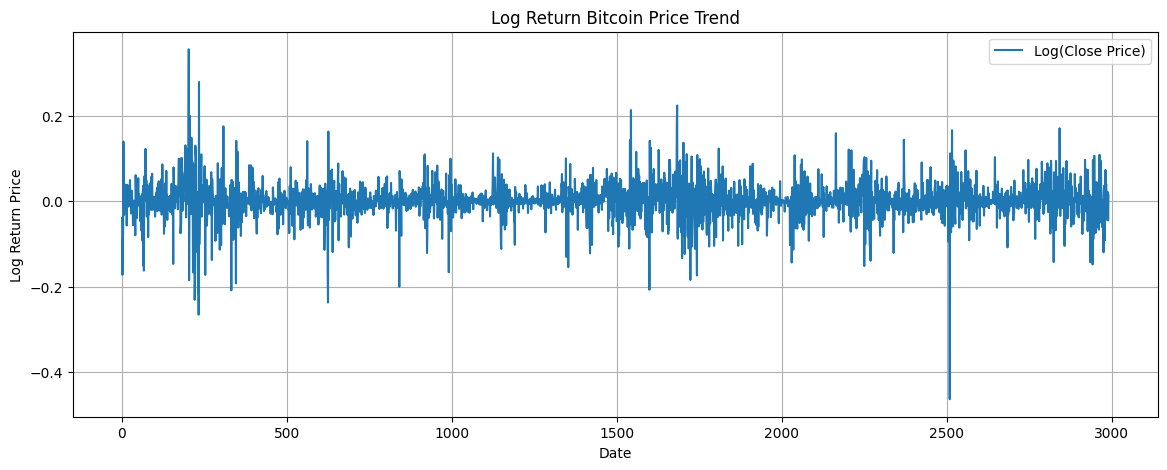

In [382]:
plt.figure(figsize=(14,5))
plt.plot(df['log_return'], label='Log(Close Price)')
plt.title('Log Return Bitcoin Price Trend')
plt.xlabel('Date')
plt.ylabel('Log Return Price')
plt.legend()
plt.grid(True)
save_plot_from_title()
plt.show()


B. ACF Plots (Seasonality Checks)

Saved plot: D:/All_Projects/crypto-forecasting-project/reports/ACF_Plot___Seasonality_Detection.png


<Figure size 1000x300 with 0 Axes>

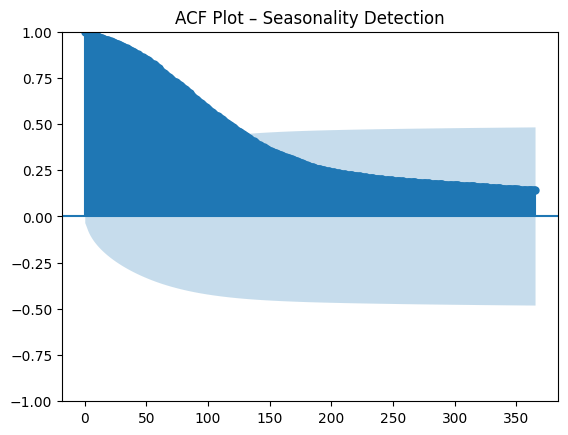

In [383]:
plt.figure(figsize=(10,3))
plot_acf(df['Close'], lags=365, )
plt.title('ACF Plot – Seasonality Detection')
save_plot_from_title()
plt.show()


##### Perform ADF Test for Stationarity

In [384]:
adf_test = adfuller(df['Close'])
print("ADF Statistic:", adf_test[0])
print("p-value:", adf_test[1])
print("Critical Values:")
for key, value in adf_test[4].items():
    print(f"   {key}: {value}")


ADF Statistic: -0.7973098451195634
p-value: 0.8199110033239144
Critical Values:
   1%: -3.4325603944919445
   5%: -2.8625166073924957
   10%: -2.567289874591689


##### Plot ACF & PACF for Lag Relationships

Saved plot: D:/All_Projects/crypto-forecasting-project/reports/PACF_Plot.png


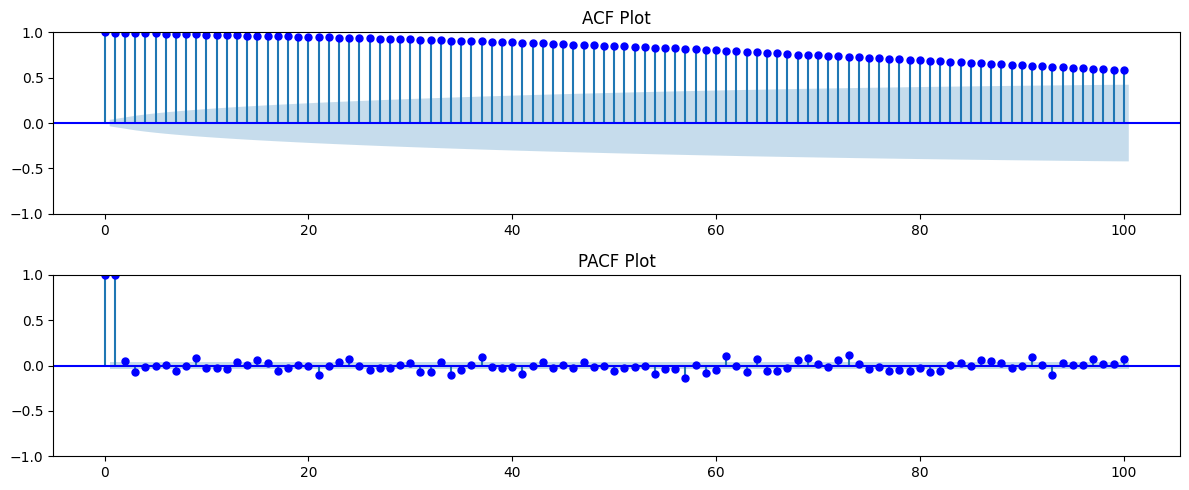

In [385]:
fig, axes = plt.subplots(2, 1, figsize=(12,5))
plot_acf(df['Close'], lags=100, ax=axes[0], color = 'blue')
plot_pacf(df['Close'], lags=100, ax=axes[1], color = 'blue')
axes[0].set_title("ACF Plot")
axes[1].set_title("PACF Plot")
plt.tight_layout()
save_plot_from_title()
plt.show()


##### Plot Moving Averages

Saved plot: D:/All_Projects/crypto-forecasting-project/reports/Moving_Averages_of_Bitcoin_Price.png


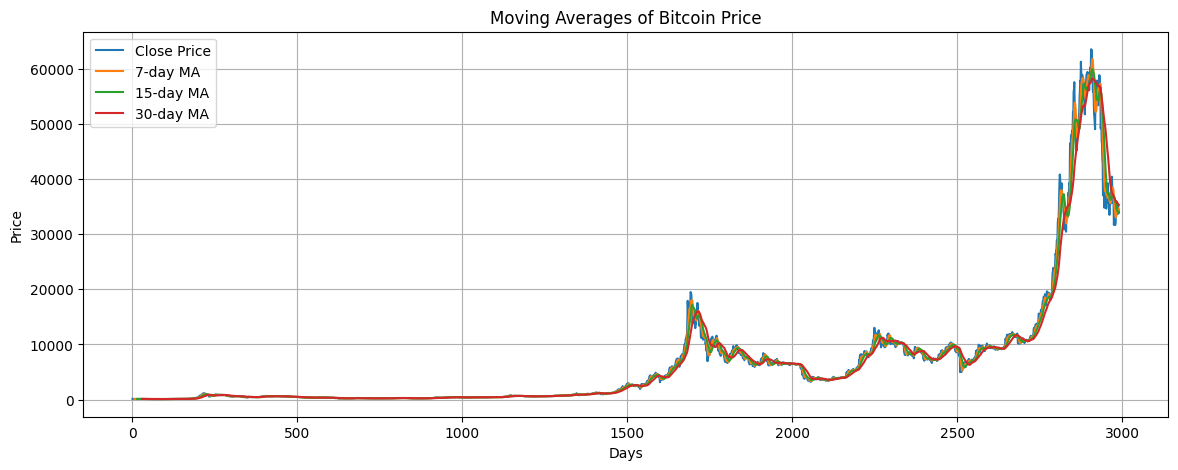

In [386]:
plt.figure(figsize=(14,5))
plt.plot(df['Close'], label='Close Price')
plt.plot(df['MA_7'], label='7-day MA')
plt.plot(df['MA_15'], label='15-day MA')
plt.plot(df["MA_30"], label='30-day MA')
plt.title("Moving Averages of Bitcoin Price")
plt.xlabel("Days")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
save_plot_from_title()
plt.show()


##### Investigate Correlation Between Volume and Price

Correlation values between features

Saved plot: D:/All_Projects/crypto-forecasting-project/reports/Correlation_Heatmap_between_Close_Price_and_Volume.png


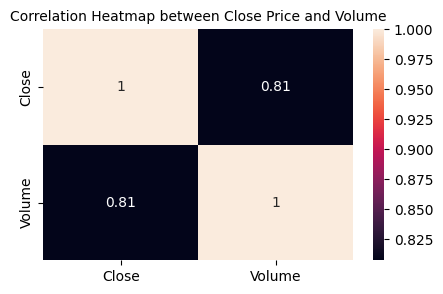

In [387]:
corr = df[['Close', 'Volume']].corr()

plt.figure(figsize=(5,3))
sns.heatmap(corr, annot = True, )
plt.title("Correlation Heatmap between Close Price and Volume", fontsize=10)
save_plot_from_title()
plt.show()


Scatter Plot

Saved plot: D:/All_Projects/crypto-forecasting-project/reports/Scatter_plot_between_Volume_vs_Close_Price.png


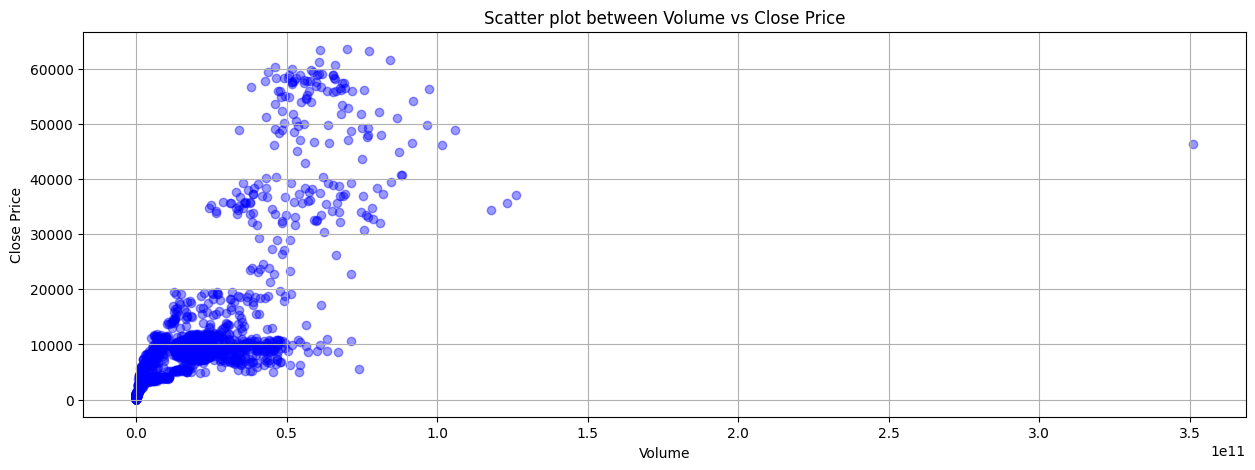

In [388]:
plt.figure(figsize=(15, 5))
plt.scatter(df['Volume'], df['Close'], alpha=0.4, color = 'blue')
plt.title("Scatter plot between Volume vs Close Price")
plt.xlabel("Volume")
plt.ylabel("Close Price")
plt.grid(True)
save_plot_from_title()
plt.show()


##### Detect Anomalies / Outliers

##### Price Distribution

Saved plot: D:/All_Projects/crypto-forecasting-project/reports/Price_Distribution__Outlier_Detection_.png


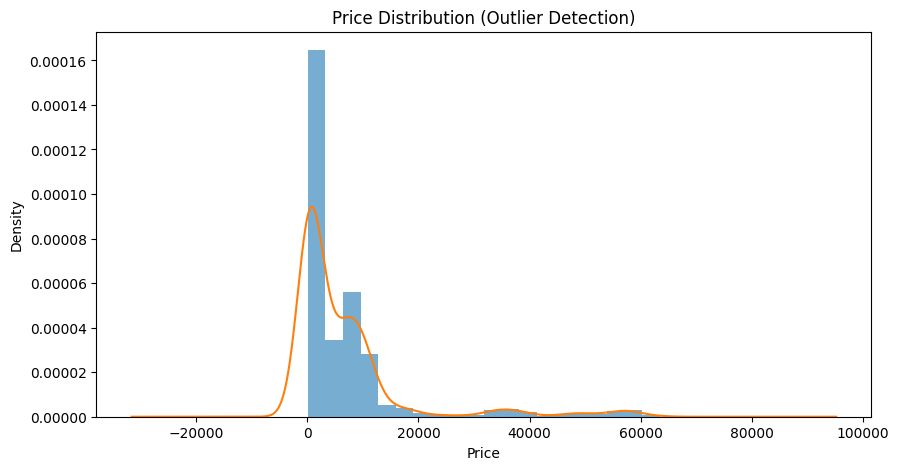

In [389]:
plt.figure(figsize=(10,5))
plt.hist(df['Close'], bins=20, density=True, alpha=0.6)
df['Close'].plot(kind='kde')
plt.title("Price Distribution (Outlier Detection)")
plt.xlabel("Price")
save_plot_from_title()
plt.show()


##### Log Return Distribution

Saved plot: D:/All_Projects/crypto-forecasting-project/reports/Log_Return_Distribution__Outlier_Detection_.png


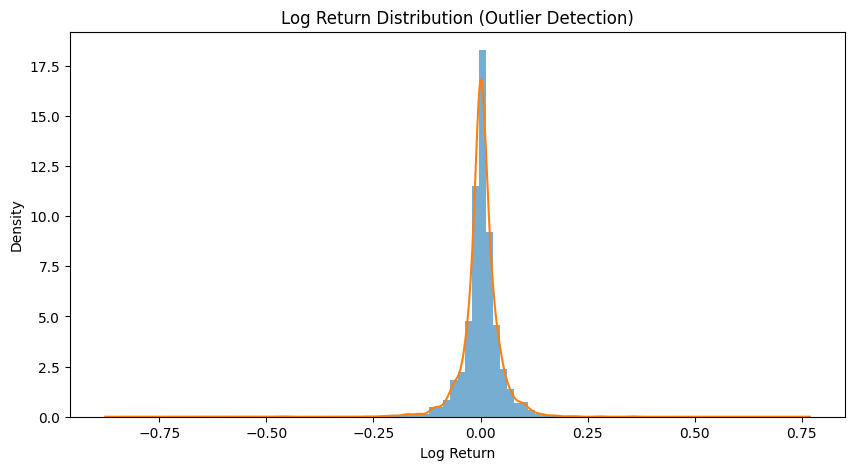

In [390]:
plt.figure(figsize=(10,5))
plt.hist(df['log_return'].dropna(), bins=50, density=True, alpha=0.6)
df['log_return'].dropna().plot(kind='kde')
plt.title("Log Return Distribution (Outlier Detection)")
plt.xlabel("Log Return")
save_plot_from_title()
plt.show()


##### Box Plot

Saved plot: D:/All_Projects/crypto-forecasting-project/reports/Box_Plot_Outlier_Detection__Log_Returns_.png


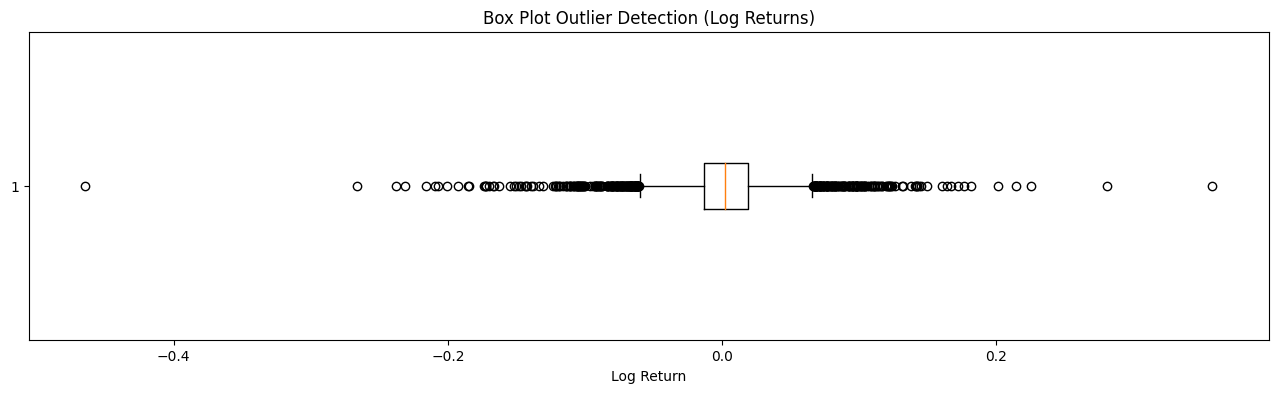

In [391]:
plt.figure(figsize=(16,4))
plt.boxplot(df['log_return'].dropna(), vert=False)
plt.title("Box Plot Outlier Detection (Log Returns)")
plt.xlabel("Log Return")
save_plot_from_title()
plt.show()


##### IQR-based Outlier Thresholds (Visual + Numeric)

In [392]:
Q1 = df['log_return'].quantile(0.25)
Q3 = df['log_return'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df['log_return'] < lower_bound) | (df['log_return'] > upper_bound)]


Saved plot: D:/All_Projects/crypto-forecasting-project/reports/IQR-Based_Outlier_Thresholds.png


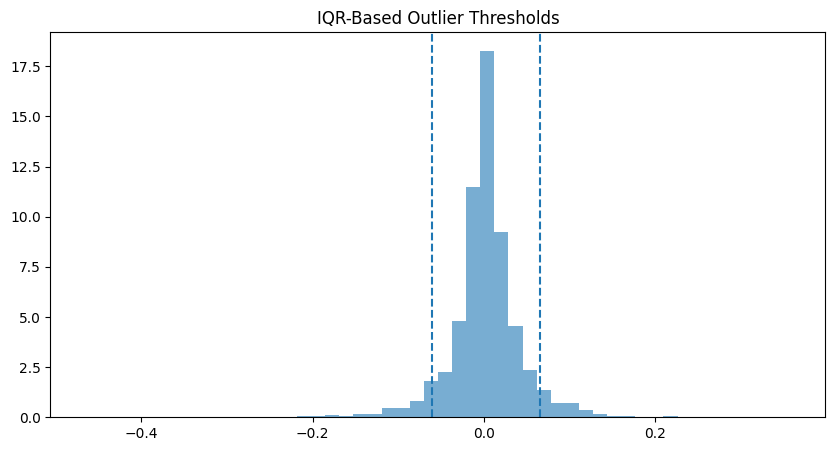

In [393]:
## Visualize bounds on distribution
plt.figure(figsize=(10,5))
plt.hist(df['log_return'].dropna(), bins=50, density=True, alpha=0.6)
plt.axvline(lower_bound, linestyle='--')
plt.axvline(upper_bound, linestyle='--')
plt.title("IQR-Based Outlier Thresholds")
save_plot_from_title()
plt.show()


##### Z-Score Distribution Plot

In [394]:
len(df['log_return'])


2991

In [395]:
df.isnull().sum()


SNo                      0
Name                     0
Symbol                   0
Date                     0
High                     0
Low                      0
Open                     0
Close                    0
Volume                   0
Marketcap                0
MA_7                     6
MA_15                   14
MA_30                   29
Trend                    0
Seasonal                 0
Residual                 0
log_return               1
volatility_7             7
volatility_15           15
volatility_30           30
volatility_regime_30     0
dtype: int64

In [396]:
df.head()


,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap,...,MA_15,MA_30,Trend,Seasonal,Residual,log_return,volatility_7,volatility_15,volatility_30,volatility_regime_30
0,1,Bitcoin,BTC,2013-04-29 23:59:59,147.488007,134.000000,134.444000,144.539993,0.0,1.603769e+09,...,NaN,NaN,124.513648,13.510565,6.515781,NaN,NaN,NaN,NaN,Low Volatility
1,2,Bitcoin,BTC,2013-04-30 23:59:59,146.929993,134.050003,144.000000,139.000000,0.0,1.542813e+09,...,NaN,NaN,122.352521,9.877990,6.769489,-0.039082,NaN,NaN,NaN,Low Volatility
2,3,Bitcoin,BTC,2013-05-01 23:59:59,139.889999,107.720001,139.000000,116.989998,0.0,1.298955e+09,...,NaN,NaN,120.357377,-2.213524,-1.153856,-0.172385,NaN,NaN,NaN,Low Volatility
3,4,Bitcoin,BTC,2013-05-02 23:59:59,125.599998,92.281898,116.379997,105.209999,0.0,1.168517e+09,...,NaN,NaN,118.507575,-8.172636,-5.124941,-0.106130,NaN,NaN,NaN,Low Volatility
4,5,Bitcoin,BTC,2013-05-03 23:59:59,108.127998,79.099998,106.250000,97.750000,0.0,1.085995e+09,...,NaN,NaN,116.770600,-9.894992,-9.125608,-0.073545,NaN,NaN,NaN,Low Volatility


Saved plot: D:/All_Projects/crypto-forecasting-project/reports/Log_Return_Scatter_Plot.png


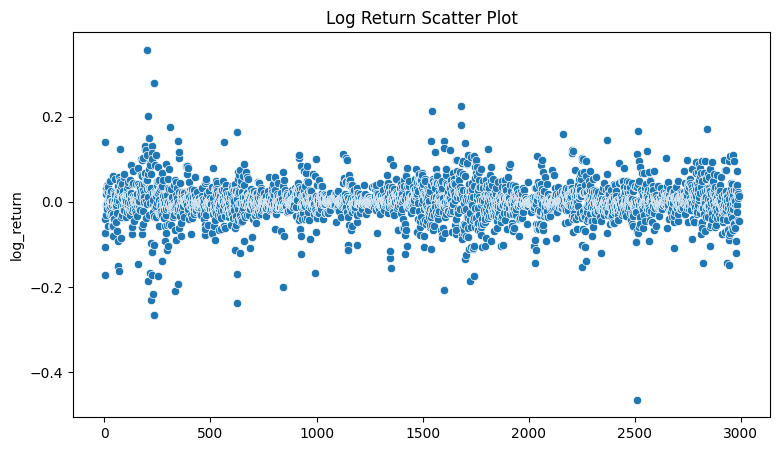

In [397]:
plt.figure(figsize = (9,5))
sns.scatterplot(df['log_return'])
plt.title("Log Return Scatter Plot")
save_plot_from_title()
plt.show()


In [398]:
df.dtypes


SNo                              int64
Name                            object
Symbol                          object
Date                    datetime64[ns]
High                           float64
Low                            float64
Open                           float64
Close                          float64
Volume                         float64
Marketcap                      float64
MA_7                           float64
MA_15                          float64
MA_30                          float64
Trend                          float64
Seasonal                       float64
Residual                       float64
log_return                     float64
volatility_7                   float64
volatility_15                  float64
volatility_30                  float64
volatility_regime_30            object
dtype: object

In [399]:
df1 = df.fillna(df.mean())


In [400]:
df1['z_score'] = zscore(df1['log_return'])
df1


,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap,...,MA_30,Trend,Seasonal,Residual,log_return,volatility_7,volatility_15,volatility_30,volatility_regime_30,z_score
0,1,Bitcoin,BTC,2013-04-29 23:59:59,147.488007,134.000000,134.444000,144.539993,0.000000e+00,1.603769e+09,...,6606.573392,124.513648,13.510565,6.515781,0.001829,0.034614,0.036281,0.037536,Low Volatility,5.073006e-18
1,2,Bitcoin,BTC,2013-04-30 23:59:59,146.929993,134.050003,144.000000,139.000000,0.000000e+00,1.542813e+09,...,6606.573392,122.352521,9.877990,6.769489,-0.039082,0.034614,0.036281,0.037536,Low Volatility,-9.571148e-01
2,3,Bitcoin,BTC,2013-05-01 23:59:59,139.889999,107.720001,139.000000,116.989998,0.000000e+00,1.298955e+09,...,6606.573392,120.357377,-2.213524,-1.153856,-0.172385,0.034614,0.036281,0.037536,Low Volatility,-4.075758e+00
3,4,Bitcoin,BTC,2013-05-02 23:59:59,125.599998,92.281898,116.379997,105.209999,0.000000e+00,1.168517e+09,...,6606.573392,118.507575,-8.172636,-5.124941,-0.106130,0.034614,0.036281,0.037536,Low Volatility,-2.525705e+00
4,5,Bitcoin,BTC,2013-05-03 23:59:59,108.127998,79.099998,106.250000,97.750000,0.000000e+00,1.085995e+09,...,6606.573392,116.770600,-9.894992,-9.125608,-0.073545,0.034614,0.036281,0.037536,Low Volatility,-1.763377e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2986,2987,Bitcoin,BTC,2021-07-02 23:59:59,33939.588699,32770.680780,33549.600177,33897.048590,3.872897e+10,6.354508e+11,...,35618.790261,34332.563133,-1095.522467,660.007923,0.009632,0.039215,0.052242,0.051774,High Volatility,1.825632e-01
2987,2988,Bitcoin,BTC,2021-07-03 23:59:59,34909.259899,33402.696536,33854.421362,34668.548402,2.438396e+10,6.499397e+11,...,35467.449674,34335.445545,-130.190373,463.293229,0.022505,0.039432,0.050547,0.051287,High Volatility,4.837258e-01
2988,2989,Bitcoin,BTC,2021-07-04 23:59:59,35937.567147,34396.477458,34665.564866,35287.779766,2.492431e+10,6.615748e+11,...,35413.895489,34327.893632,1070.089444,-110.203309,0.017704,0.028708,0.050795,0.050286,High Volatility,3.714033e-01
2989,2990,Bitcoin,BTC,2021-07-05 23:59:59,35284.344430,33213.661034,35284.344430,33746.002456,2.672155e+10,6.326962e+11,...,35353.696946,34308.663792,-446.144558,-116.516778,-0.044675,0.033890,0.052035,0.050490,High Volatility,-1.087951e+00


In [401]:
# df2 = df.fillna(df.mean())
# df2['z_score'] = zscore(df2['log_return'])
# df2
# plt.figure(figsize=(10,5))
# plt.hist(np.abs(df2['z_score']), bins=50, density=True)
# plt.axvline(3, linestyle='--')
# plt.axvline(-3, linestyle='--')
# plt.title("Z-Score Distribution for Outlier Detection")
# plt.xlabel("Z-Score")
# plt.show()


Saved plot: D:/All_Projects/crypto-forecasting-project/reports/Z-Score_Distribution_for_Outlier_Detection.png


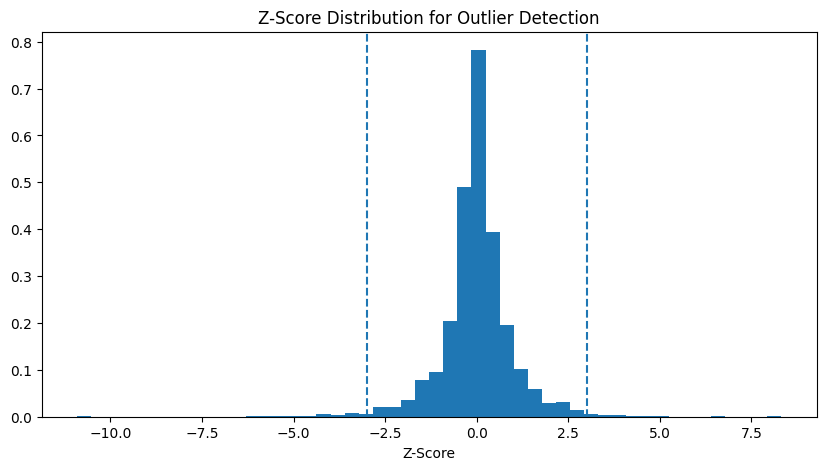

In [402]:
plt.figure(figsize=(10,5))
plt.hist(df1['z_score'], bins=50, density=True)
plt.axvline(3, linestyle='--')
plt.axvline(-3, linestyle='--')
plt.title("Z-Score Distribution for Outlier Detection")
plt.xlabel("Z-Score")
save_plot_from_title()
plt.show()


Saved plot: D:/All_Projects/crypto-forecasting-project/reports/QQ_Plot_Outlier_Detection.png


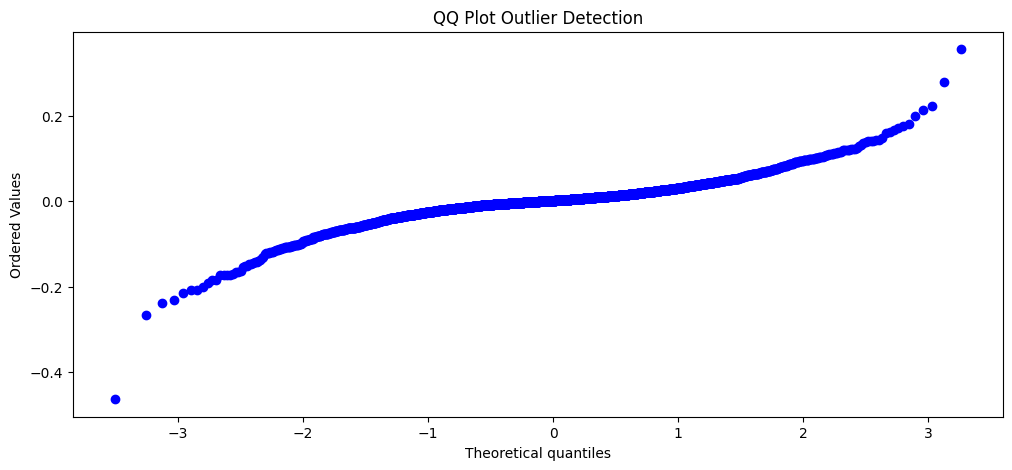

In [403]:
import scipy.stats as stats

plt.figure(figsize=(12,5))
stats.probplot(df['log_return'], dist="norm", plot=plt)
plt.title("QQ Plot Outlier Detection")
save_plot_from_title()
plt.show()


In [404]:
df1['log_return_capped'] = df1['log_return'].clip(lower_bound, upper_bound)
df1[['log_return','log_return_capped']]


,log_return,log_return_capped
0,0.001829,0.001829
1,-0.039082,-0.039082
2,-0.172385,-0.060476
3,-0.106130,-0.060476
4,-0.073545,-0.060476
...,...,...
2986,0.009632,0.009632
2987,0.022505,0.022505
2988,0.017704,0.017704
2989,-0.044675,-0.044675


Saved plot: D:/All_Projects/crypto-forecasting-project/reports/Log_Return_Distribution__Outlier_Detection_.png


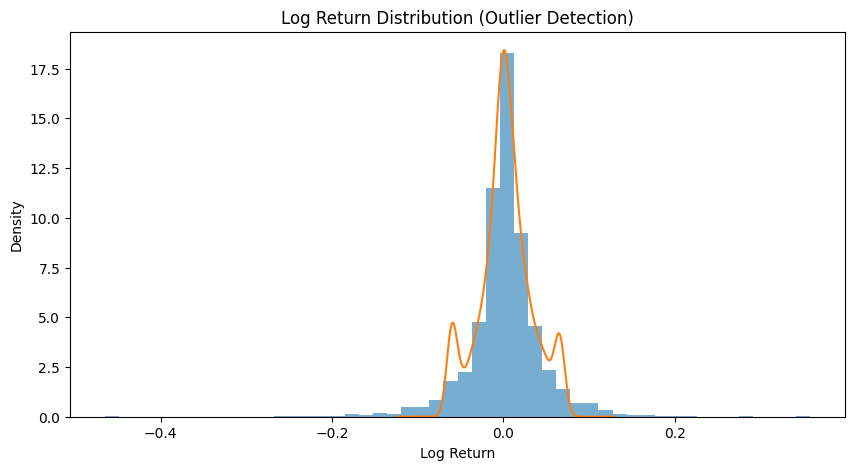

In [405]:
plt.figure(figsize=(10,5))
plt.hist(df1['log_return'], bins=50, density=True, alpha=0.6)
df1['log_return_capped'].dropna().plot(kind='kde')
plt.title("Log Return Distribution (Outlier Detection)")
plt.xlabel("Log Return")
save_plot_from_title()
plt.show()


In [406]:
df1


,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap,...,Trend,Seasonal,Residual,log_return,volatility_7,volatility_15,volatility_30,volatility_regime_30,z_score,log_return_capped
0,1,Bitcoin,BTC,2013-04-29 23:59:59,147.488007,134.000000,134.444000,144.539993,0.000000e+00,1.603769e+09,...,124.513648,13.510565,6.515781,0.001829,0.034614,0.036281,0.037536,Low Volatility,5.073006e-18,0.001829
1,2,Bitcoin,BTC,2013-04-30 23:59:59,146.929993,134.050003,144.000000,139.000000,0.000000e+00,1.542813e+09,...,122.352521,9.877990,6.769489,-0.039082,0.034614,0.036281,0.037536,Low Volatility,-9.571148e-01,-0.039082
2,3,Bitcoin,BTC,2013-05-01 23:59:59,139.889999,107.720001,139.000000,116.989998,0.000000e+00,1.298955e+09,...,120.357377,-2.213524,-1.153856,-0.172385,0.034614,0.036281,0.037536,Low Volatility,-4.075758e+00,-0.060476
3,4,Bitcoin,BTC,2013-05-02 23:59:59,125.599998,92.281898,116.379997,105.209999,0.000000e+00,1.168517e+09,...,118.507575,-8.172636,-5.124941,-0.106130,0.034614,0.036281,0.037536,Low Volatility,-2.525705e+00,-0.060476
4,5,Bitcoin,BTC,2013-05-03 23:59:59,108.127998,79.099998,106.250000,97.750000,0.000000e+00,1.085995e+09,...,116.770600,-9.894992,-9.125608,-0.073545,0.034614,0.036281,0.037536,Low Volatility,-1.763377e+00,-0.060476
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2986,2987,Bitcoin,BTC,2021-07-02 23:59:59,33939.588699,32770.680780,33549.600177,33897.048590,3.872897e+10,6.354508e+11,...,34332.563133,-1095.522467,660.007923,0.009632,0.039215,0.052242,0.051774,High Volatility,1.825632e-01,0.009632
2987,2988,Bitcoin,BTC,2021-07-03 23:59:59,34909.259899,33402.696536,33854.421362,34668.548402,2.438396e+10,6.499397e+11,...,34335.445545,-130.190373,463.293229,0.022505,0.039432,0.050547,0.051287,High Volatility,4.837258e-01,0.022505
2988,2989,Bitcoin,BTC,2021-07-04 23:59:59,35937.567147,34396.477458,34665.564866,35287.779766,2.492431e+10,6.615748e+11,...,34327.893632,1070.089444,-110.203309,0.017704,0.028708,0.050795,0.050286,High Volatility,3.714033e-01,0.017704
2989,2990,Bitcoin,BTC,2021-07-05 23:59:59,35284.344430,33213.661034,35284.344430,33746.002456,2.672155e+10,6.326962e+11,...,34308.663792,-446.144558,-116.516778,-0.044675,0.033890,0.052035,0.050490,High Volatility,-1.087951e+00,-0.044675


Saved plot: D:/All_Projects/crypto-forecasting-project/reports/Z-Score_Time_Series_after_Outlier_Removal.png


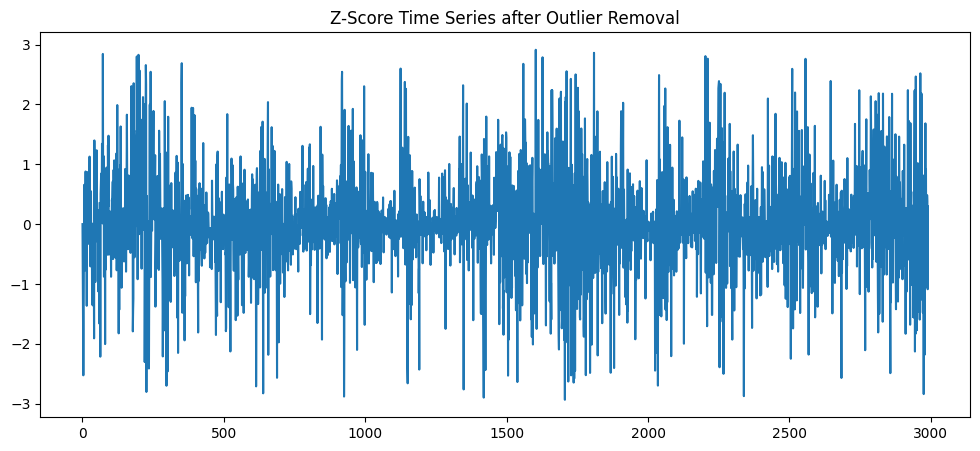

In [407]:
outlier_removal_df = df1[np.abs(df1['z_score']) <= 3]
plt.figure(figsize=(12,5))
plt.plot(outlier_removal_df.z_score)
plt.title("Z-Score Time Series after Outlier Removal")
save_plot_from_title()
plt.show()


B. Visualizing Outliers

In [408]:
outlier_removal_df


,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap,...,Trend,Seasonal,Residual,log_return,volatility_7,volatility_15,volatility_30,volatility_regime_30,z_score,log_return_capped
0,1,Bitcoin,BTC,2013-04-29 23:59:59,147.488007,134.000000,134.444000,144.539993,0.000000e+00,1.603769e+09,...,124.513648,13.510565,6.515781,0.001829,0.034614,0.036281,0.037536,Low Volatility,5.073006e-18,0.001829
1,2,Bitcoin,BTC,2013-04-30 23:59:59,146.929993,134.050003,144.000000,139.000000,0.000000e+00,1.542813e+09,...,122.352521,9.877990,6.769489,-0.039082,0.034614,0.036281,0.037536,Low Volatility,-9.571148e-01,-0.039082
3,4,Bitcoin,BTC,2013-05-02 23:59:59,125.599998,92.281898,116.379997,105.209999,0.000000e+00,1.168517e+09,...,118.507575,-8.172636,-5.124941,-0.106130,0.034614,0.036281,0.037536,Low Volatility,-2.525705e+00,-0.060476
4,5,Bitcoin,BTC,2013-05-03 23:59:59,108.127998,79.099998,106.250000,97.750000,0.000000e+00,1.085995e+09,...,116.770600,-9.894992,-9.125608,-0.073545,0.034614,0.036281,0.037536,Low Volatility,-1.763377e+00,-0.060476
6,7,Bitcoin,BTC,2013-05-05 23:59:59,118.800003,107.142998,112.900002,115.910004,0.000000e+00,1.288693e+09,...,113.531855,2.108437,0.269712,0.029861,0.034614,0.036281,0.037536,Low Volatility,6.558178e-01,0.029861
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2986,2987,Bitcoin,BTC,2021-07-02 23:59:59,33939.588699,32770.680780,33549.600177,33897.048590,3.872897e+10,6.354508e+11,...,34332.563133,-1095.522467,660.007923,0.009632,0.039215,0.052242,0.051774,High Volatility,1.825632e-01,0.009632
2987,2988,Bitcoin,BTC,2021-07-03 23:59:59,34909.259899,33402.696536,33854.421362,34668.548402,2.438396e+10,6.499397e+11,...,34335.445545,-130.190373,463.293229,0.022505,0.039432,0.050547,0.051287,High Volatility,4.837258e-01,0.022505
2988,2989,Bitcoin,BTC,2021-07-04 23:59:59,35937.567147,34396.477458,34665.564866,35287.779766,2.492431e+10,6.615748e+11,...,34327.893632,1070.089444,-110.203309,0.017704,0.028708,0.050795,0.050286,High Volatility,3.714033e-01,0.017704
2989,2990,Bitcoin,BTC,2021-07-05 23:59:59,35284.344430,33213.661034,35284.344430,33746.002456,2.672155e+10,6.326962e+11,...,34308.663792,-446.144558,-116.516778,-0.044675,0.033890,0.052035,0.050490,High Volatility,-1.087951e+00,-0.044675


Saved plot: D:/All_Projects/crypto-forecasting-project/reports/Outlier_Detection.png


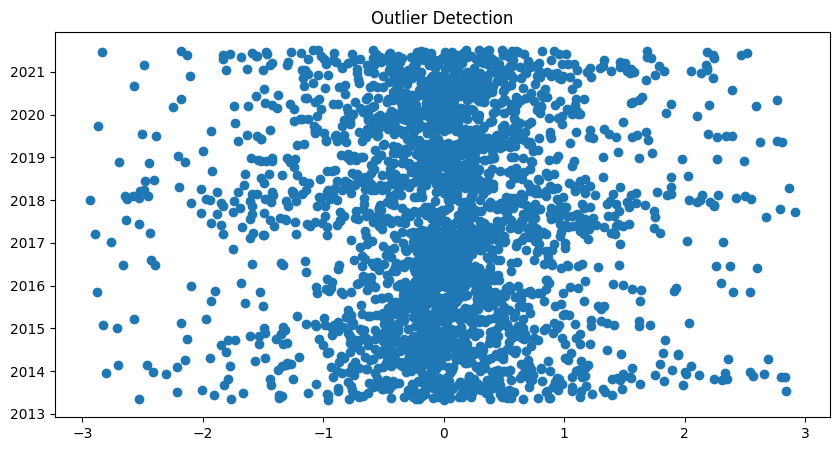

In [409]:
plt.figure(figsize=(10,5))
plt.scatter(outlier_removal_df.z_score, outlier_removal_df.Date)
plt.title("Outlier Detection")
save_plot_from_title()
plt.show()


Saved plot: D:/All_Projects/crypto-forecasting-project/reports/Box_Plot_Outlier_Detection__Close_Price_.png


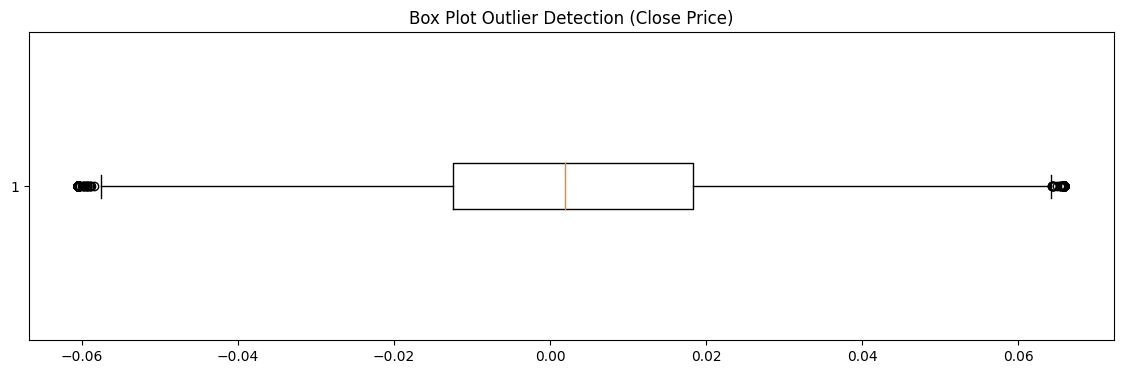

In [410]:
plt.figure(figsize=(14,4))
plt.boxplot(outlier_removal_df.log_return_capped, vert=False)
plt.title("Box Plot Outlier Detection (Close Price)")
save_plot_from_title()
plt.show()      


In [411]:
df1.head(40)


,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap,...,Trend,Seasonal,Residual,log_return,volatility_7,volatility_15,volatility_30,volatility_regime_30,z_score,log_return_capped
0,1,Bitcoin,BTC,2013-04-29 23:59:59,147.488007,134.000000,134.444000,144.539993,0.0,1.603769e+09,...,124.513648,13.510565,6.515781,0.001829,0.034614,0.036281,0.037536,Low Volatility,5.073006e-18,0.001829
1,2,Bitcoin,BTC,2013-04-30 23:59:59,146.929993,134.050003,144.000000,139.000000,0.0,1.542813e+09,...,122.352521,9.877990,6.769489,-0.039082,0.034614,0.036281,0.037536,Low Volatility,-9.571148e-01,-0.039082
2,3,Bitcoin,BTC,2013-05-01 23:59:59,139.889999,107.720001,139.000000,116.989998,0.0,1.298955e+09,...,120.357377,-2.213524,-1.153856,-0.172385,0.034614,0.036281,0.037536,Low Volatility,-4.075758e+00,-0.060476
3,4,Bitcoin,BTC,2013-05-02 23:59:59,125.599998,92.281898,116.379997,105.209999,0.0,1.168517e+09,...,118.507575,-8.172636,-5.124941,-0.106130,0.034614,0.036281,0.037536,Low Volatility,-2.525705e+00,-0.060476
4,5,Bitcoin,BTC,2013-05-03 23:59:59,108.127998,79.099998,106.250000,97.750000,0.0,1.085995e+09,...,116.770600,-9.894992,-9.125608,-0.073545,0.034614,0.036281,0.037536,Low Volatility,-1.763377e+00,-0.060476
5,6,Bitcoin,BTC,2013-05-04 23:59:59,115.000000,92.500000,98.099998,112.500000,0.0,1.250317e+09,...,115.115049,-0.856087,-1.758962,0.140540,0.034614,0.036281,0.037536,Low Volatility,3.245170e+00,0.065881
6,7,Bitcoin,BTC,2013-05-05 23:59:59,118.800003,107.142998,112.900002,115.910004,0.0,1.288693e+09,...,113.531855,2.108437,0.269712,0.029861,0.034614,0.036281,0.037536,Low Volatility,6.558178e-01,0.029861
7,8,Bitcoin,BTC,2013-05-06 23:59:59,124.663002,106.639999,115.980003,112.300003,0.0,1.249023e+09,...,112.364400,8.478740,-8.543137,-0.031640,0.100384,0.036281,0.037536,Low Volatility,-7.830052e-01,-0.031640
8,9,Bitcoin,BTC,2013-05-07 23:59:59,113.444000,97.699997,112.250000,111.500000,0.0,1.240594e+09,...,112.709401,5.277202,-6.486603,-0.007149,0.100947,0.036281,0.037536,Low Volatility,-2.100385e-01,-0.007149
9,10,Bitcoin,BTC,2013-05-08 23:59:59,115.779999,109.599998,109.599998,113.566002,0.0,1.264049e+09,...,113.194003,-1.662594,2.034593,0.018360,0.080186,0.036281,0.037536,Low Volatility,3.867449e-01,0.018360


## Data Preprocessing

In [412]:
data = df1.sort_values('Date')
data.set_index('Date', inplace=True)


In [413]:
data


,SNo,Name,Symbol,High,Low,Open,Close,Volume,Marketcap,MA_7,...,Trend,Seasonal,Residual,log_return,volatility_7,volatility_15,volatility_30,volatility_regime_30,z_score,log_return_capped
Date,,,,,,,,,,,,,,,,,,,,,
2013-04-29 23:59:59,1,Bitcoin,BTC,147.488007,134.000000,134.444000,144.539993,0.000000e+00,1.603769e+09,6690.163677,...,124.513648,13.510565,6.515781,0.001829,0.034614,0.036281,0.037536,Low Volatility,5.073006e-18,0.001829
2013-04-30 23:59:59,2,Bitcoin,BTC,146.929993,134.050003,144.000000,139.000000,0.000000e+00,1.542813e+09,6690.163677,...,122.352521,9.877990,6.769489,-0.039082,0.034614,0.036281,0.037536,Low Volatility,-9.571148e-01,-0.039082
2013-05-01 23:59:59,3,Bitcoin,BTC,139.889999,107.720001,139.000000,116.989998,0.000000e+00,1.298955e+09,6690.163677,...,120.357377,-2.213524,-1.153856,-0.172385,0.034614,0.036281,0.037536,Low Volatility,-4.075758e+00,-0.060476
2013-05-02 23:59:59,4,Bitcoin,BTC,125.599998,92.281898,116.379997,105.209999,0.000000e+00,1.168517e+09,6690.163677,...,118.507575,-8.172636,-5.124941,-0.106130,0.034614,0.036281,0.037536,Low Volatility,-2.525705e+00,-0.060476
2013-05-03 23:59:59,5,Bitcoin,BTC,108.127998,79.099998,106.250000,97.750000,0.000000e+00,1.085995e+09,6690.163677,...,116.770600,-9.894992,-9.125608,-0.073545,0.034614,0.036281,0.037536,Low Volatility,-1.763377e+00,-0.060476
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-02 23:59:59,2987,Bitcoin,BTC,33939.588699,32770.680780,33549.600177,33897.048590,3.872897e+10,6.354508e+11,34235.434114,...,34332.563133,-1095.522467,660.007923,0.009632,0.039215,0.052242,0.051774,High Volatility,1.825632e-01,0.009632
2021-07-03 23:59:59,2988,Bitcoin,BTC,34909.259899,33402.696536,33854.421362,34668.548402,2.438396e+10,6.499397e+11,34590.044219,...,34335.445545,-130.190373,463.293229,0.022505,0.039432,0.050547,0.051287,High Volatility,4.837258e-01,0.022505
2021-07-04 23:59:59,2989,Bitcoin,BTC,35937.567147,34396.477458,34665.564866,35287.779766,2.492431e+10,6.615748e+11,34681.206387,...,34327.893632,1070.089444,-110.203309,0.017704,0.028708,0.050795,0.050286,High Volatility,3.714033e-01,0.017704


In [414]:
# Ensure datetime index
data.index = pd.to_datetime(data.index)
data.head()


,SNo,Name,Symbol,High,Low,Open,Close,Volume,Marketcap,MA_7,...,Trend,Seasonal,Residual,log_return,volatility_7,volatility_15,volatility_30,volatility_regime_30,z_score,log_return_capped
Date,,,,,,,,,,,,,,,,,,,,,
2013-04-29 23:59:59,1,Bitcoin,BTC,147.488007,134.000000,134.444000,144.539993,0.0,1.603769e+09,6690.163677,...,124.513648,13.510565,6.515781,0.001829,0.034614,0.036281,0.037536,Low Volatility,5.073006e-18,0.001829
2013-04-30 23:59:59,2,Bitcoin,BTC,146.929993,134.050003,144.000000,139.000000,0.0,1.542813e+09,6690.163677,...,122.352521,9.877990,6.769489,-0.039082,0.034614,0.036281,0.037536,Low Volatility,-9.571148e-01,-0.039082
2013-05-01 23:59:59,3,Bitcoin,BTC,139.889999,107.720001,139.000000,116.989998,0.0,1.298955e+09,6690.163677,...,120.357377,-2.213524,-1.153856,-0.172385,0.034614,0.036281,0.037536,Low Volatility,-4.075758e+00,-0.060476
2013-05-02 23:59:59,4,Bitcoin,BTC,125.599998,92.281898,116.379997,105.209999,0.0,1.168517e+09,6690.163677,...,118.507575,-8.172636,-5.124941,-0.106130,0.034614,0.036281,0.037536,Low Volatility,-2.525705e+00,-0.060476
2013-05-03 23:59:59,5,Bitcoin,BTC,108.127998,79.099998,106.250000,97.750000,0.0,1.085995e+09,6690.163677,...,116.770600,-9.894992,-9.125608,-0.073545,0.034614,0.036281,0.037536,Low Volatility,-1.763377e+00,-0.060476


In [415]:
# Check missing dates
missing_dates = pd.date_range(start=data.index.min(), end=data.index.max(), freq='D').difference(data.index)
print(f"Missing timestamps: {len(missing_dates)}")


Missing timestamps: 0


In [416]:
data.columns


Index(['SNo', 'Name', 'Symbol', 'High', 'Low', 'Open', 'Close', 'Volume',
       'Marketcap', 'MA_7', 'MA_15', 'MA_30', 'Trend', 'Seasonal', 'Residual',
       'log_return', 'volatility_7', 'volatility_15', 'volatility_30',
       'volatility_regime_30', 'z_score', 'log_return_capped'],
      dtype='object')

#### Scale data using training-only fit (no leakage)
##### Chronological Split (Used Before Scaling)

In [417]:
def create_lag_features(data: pd.DataFrame, target_col: str, max_lag: int = 30) -> pd.DataFrame:
    """
    Create lag features for a time-series target column.
    Parameters:
     data : pd.DataFrame
        Time-indexed dataframe
     target_col : str
        Target column name (e.g., 'Close')
     max_lag : int
        Number of lag features to create
    Returns:
    pd.DataFrame
        DataFrame with lag features
    """
    df_lag = data.copy()
    for lag in range(1, max_lag + 1):
        df_lag[f'{target_col}_lag_{lag}'] = df_lag[target_col].shift(lag)
    df_lag.dropna(inplace=True)
    return df_lag


In [418]:
final_data = data.copy()


In [419]:
final_data[['High', 'Low', 'Open', 'Close', 'Volume', 'Marketcap', 'MA_7', 'MA_15', 'MA_30', 'log_return', 'volatility_7', 'volatility_15', 'volatility_30', 'volatility_regime_30', 'z_score', 'log_return_capped']]


,High,Low,Open,Close,Volume,Marketcap,MA_7,MA_15,MA_30,log_return,volatility_7,volatility_15,volatility_30,volatility_regime_30,z_score,log_return_capped
Date,,,,,,,,,,,,,,,,
2013-04-29 23:59:59,147.488007,134.000000,134.444000,144.539993,0.000000e+00,1.603769e+09,6690.163677,6661.912140,6606.573392,0.001829,0.034614,0.036281,0.037536,Low Volatility,5.073006e-18,0.001829
2013-04-30 23:59:59,146.929993,134.050003,144.000000,139.000000,0.000000e+00,1.542813e+09,6690.163677,6661.912140,6606.573392,-0.039082,0.034614,0.036281,0.037536,Low Volatility,-9.571148e-01,-0.039082
2013-05-01 23:59:59,139.889999,107.720001,139.000000,116.989998,0.000000e+00,1.298955e+09,6690.163677,6661.912140,6606.573392,-0.172385,0.034614,0.036281,0.037536,Low Volatility,-4.075758e+00,-0.060476
2013-05-02 23:59:59,125.599998,92.281898,116.379997,105.209999,0.000000e+00,1.168517e+09,6690.163677,6661.912140,6606.573392,-0.106130,0.034614,0.036281,0.037536,Low Volatility,-2.525705e+00,-0.060476
2013-05-03 23:59:59,108.127998,79.099998,106.250000,97.750000,0.000000e+00,1.085995e+09,6690.163677,6661.912140,6606.573392,-0.073545,0.034614,0.036281,0.037536,Low Volatility,-1.763377e+00,-0.060476
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-02 23:59:59,33939.588699,32770.680780,33549.600177,33897.048590,3.872897e+10,6.354508e+11,34235.434114,34063.669852,35618.790261,0.009632,0.039215,0.052242,0.051774,High Volatility,1.825632e-01,0.009632
2021-07-03 23:59:59,34909.259899,33402.696536,33854.421362,34668.548402,2.438396e+10,6.499397e+11,34590.044219,33989.090093,35467.449674,0.022505,0.039432,0.050547,0.051287,High Volatility,4.837258e-01,0.022505
2021-07-04 23:59:59,35937.567147,34396.477458,34665.564866,35287.779766,2.492431e+10,6.615748e+11,34681.206387,33967.217460,35413.895489,0.017704,0.028708,0.050795,0.050286,High Volatility,3.714033e-01,0.017704


In [420]:
encoded_data = final_data.copy()


In [421]:
encode = {"Low Volatility":0, "High Volatility":1}
encoded_data["volatility_regime_30"] = encoded_data.volatility_regime_30.map(encode)
encoded_data


,SNo,Name,Symbol,High,Low,Open,Close,Volume,Marketcap,MA_7,...,Trend,Seasonal,Residual,log_return,volatility_7,volatility_15,volatility_30,volatility_regime_30,z_score,log_return_capped
Date,,,,,,,,,,,,,,,,,,,,,
2013-04-29 23:59:59,1,Bitcoin,BTC,147.488007,134.000000,134.444000,144.539993,0.000000e+00,1.603769e+09,6690.163677,...,124.513648,13.510565,6.515781,0.001829,0.034614,0.036281,0.037536,0,5.073006e-18,0.001829
2013-04-30 23:59:59,2,Bitcoin,BTC,146.929993,134.050003,144.000000,139.000000,0.000000e+00,1.542813e+09,6690.163677,...,122.352521,9.877990,6.769489,-0.039082,0.034614,0.036281,0.037536,0,-9.571148e-01,-0.039082
2013-05-01 23:59:59,3,Bitcoin,BTC,139.889999,107.720001,139.000000,116.989998,0.000000e+00,1.298955e+09,6690.163677,...,120.357377,-2.213524,-1.153856,-0.172385,0.034614,0.036281,0.037536,0,-4.075758e+00,-0.060476
2013-05-02 23:59:59,4,Bitcoin,BTC,125.599998,92.281898,116.379997,105.209999,0.000000e+00,1.168517e+09,6690.163677,...,118.507575,-8.172636,-5.124941,-0.106130,0.034614,0.036281,0.037536,0,-2.525705e+00,-0.060476
2013-05-03 23:59:59,5,Bitcoin,BTC,108.127998,79.099998,106.250000,97.750000,0.000000e+00,1.085995e+09,6690.163677,...,116.770600,-9.894992,-9.125608,-0.073545,0.034614,0.036281,0.037536,0,-1.763377e+00,-0.060476
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-02 23:59:59,2987,Bitcoin,BTC,33939.588699,32770.680780,33549.600177,33897.048590,3.872897e+10,6.354508e+11,34235.434114,...,34332.563133,-1095.522467,660.007923,0.009632,0.039215,0.052242,0.051774,1,1.825632e-01,0.009632
2021-07-03 23:59:59,2988,Bitcoin,BTC,34909.259899,33402.696536,33854.421362,34668.548402,2.438396e+10,6.499397e+11,34590.044219,...,34335.445545,-130.190373,463.293229,0.022505,0.039432,0.050547,0.051287,1,4.837258e-01,0.022505
2021-07-04 23:59:59,2989,Bitcoin,BTC,35937.567147,34396.477458,34665.564866,35287.779766,2.492431e+10,6.615748e+11,34681.206387,...,34327.893632,1070.089444,-110.203309,0.017704,0.028708,0.050795,0.050286,1,3.714033e-01,0.017704


In [422]:
added_lag_features_df = create_lag_features(encoded_data, target_col='Close', max_lag=30)
added_lag_features_df.columns


Index(['SNo', 'Name', 'Symbol', 'High', 'Low', 'Open', 'Close', 'Volume',
       'Marketcap', 'MA_7', 'MA_15', 'MA_30', 'Trend', 'Seasonal', 'Residual',
       'log_return', 'volatility_7', 'volatility_15', 'volatility_30',
       'volatility_regime_30', 'z_score', 'log_return_capped', 'Close_lag_1',
       'Close_lag_2', 'Close_lag_3', 'Close_lag_4', 'Close_lag_5',
       'Close_lag_6', 'Close_lag_7', 'Close_lag_8', 'Close_lag_9',
       'Close_lag_10', 'Close_lag_11', 'Close_lag_12', 'Close_lag_13',
       'Close_lag_14', 'Close_lag_15', 'Close_lag_16', 'Close_lag_17',
       'Close_lag_18', 'Close_lag_19', 'Close_lag_20', 'Close_lag_21',
       'Close_lag_22', 'Close_lag_23', 'Close_lag_24', 'Close_lag_25',
       'Close_lag_26', 'Close_lag_27', 'Close_lag_28', 'Close_lag_29',
       'Close_lag_30'],
      dtype='object')

In [423]:
added_lag_features_df['target'] = added_lag_features_df['log_return'].shift(-1)
added_lag_features_df.head()


,SNo,Name,Symbol,High,Low,Open,Close,Volume,Marketcap,MA_7,...,Close_lag_22,Close_lag_23,Close_lag_24,Close_lag_25,Close_lag_26,Close_lag_27,Close_lag_28,Close_lag_29,Close_lag_30,target
Date,,,,,,,,,,,,,,,,,,,,,
2013-05-29 23:59:59,31,Bitcoin,BTC,132.589996,127.662003,129.000000,132.300003,0.0,1.483735e+09,130.914998,...,111.500000,112.300003,115.910004,112.500000,97.750000,105.209999,116.989998,139.000000,144.539993,-0.026819
2013-05-30 23:59:59,32,Bitcoin,BTC,132.250000,127.000000,132.250000,128.798996,0.0,1.445054e+09,131.214855,...,113.566002,111.500000,112.300003,115.910004,112.500000,97.750000,105.209999,116.989998,139.000000,0.001559
2013-05-31 23:59:59,33,Bitcoin,BTC,129.899994,126.400002,128.798996,129.000000,0.0,1.447870e+09,130.614855,...,112.669998,113.566002,111.500000,112.300003,115.910004,112.500000,97.750000,105.209999,116.989998,0.002323
2013-06-01 23:59:59,34,Bitcoin,BTC,129.779999,127.198997,128.815002,129.300003,0.0,1.451916e+09,130.231999,...,117.199997,112.669998,113.566002,111.500000,112.300003,115.910004,112.500000,97.750000,105.209999,-0.055724
2013-06-02 23:59:59,35,Bitcoin,BTC,129.399994,115.050003,129.300003,122.292000,0.0,1.373837e+09,128.633714,...,115.242996,117.199997,112.669998,113.566002,111.500000,112.300003,115.910004,112.500000,97.750000,-0.000573


In [424]:
INPUT_FEATURES = ['Volume', 'Marketcap', # Market information
                  'MA_7', 'MA_15', 'MA_30', # Trend indicators
                  'volatility_7', 'volatility_15', 'volatility_30', # Volatility indicators (CRITICAL for crypto)
                  'volatility_regime_30', # Regime & distribution info
                  'Close_lag_1', 'Close_lag_2', 'Close_lag_3', 'Close_lag_4', 'Close_lag_5', 'Close_lag_6', 
                  'Close_lag_7', 'Close_lag_8', 'Close_lag_9', 'Close_lag_10', 'Close_lag_11', 'Close_lag_12', 
                  'Close_lag_13', 'Close_lag_14', 'Close_lag_15', 'Close_lag_16', 'Close_lag_17', 'Close_lag_18', 
                  'Close_lag_19', 'Close_lag_20', 'Close_lag_21', 'Close_lag_22', 'Close_lag_23', 'Close_lag_24', 
                  'Close_lag_25', 'Close_lag_26', 'Close_lag_27', 'Close_lag_28', 'Close_lag_29', 'Close_lag_30']
TARGET = 'target'


In [425]:
model_df = added_lag_features_df[INPUT_FEATURES + ['target']].dropna()
model_df


,Volume,Marketcap,MA_7,MA_15,MA_30,volatility_7,volatility_15,volatility_30,volatility_regime_30,Close_lag_1,...,Close_lag_22,Close_lag_23,Close_lag_24,Close_lag_25,Close_lag_26,Close_lag_27,Close_lag_28,Close_lag_29,Close_lag_30,target
Date,,,,,,,,,,,,,,,,,,,,,
2013-05-29 23:59:59,0.000000e+00,1.483735e+09,130.914998,125.777132,120.032533,0.026074,0.021329,0.053742,1,129.000000,...,111.500000,112.300003,115.910004,112.500000,97.750000,105.209999,116.989998,139.000000,144.539993,-0.026819
2013-05-30 23:59:59,0.000000e+00,1.445054e+09,131.214855,126.749065,119.692499,0.028498,0.023139,0.053504,1,132.300003,...,113.566002,111.500000,112.300003,115.910004,112.500000,97.750000,105.209999,116.989998,139.000000,0.001559
2013-05-31 23:59:59,0.000000e+00,1.447870e+09,130.614855,127.431732,120.092833,0.019426,0.021523,0.042822,0,128.798996,...,112.669998,113.566002,111.500000,112.300003,115.910004,112.500000,97.750000,105.209999,116.989998,0.002323
2013-06-01 23:59:59,0.000000e+00,1.451916e+09,130.231999,127.850732,120.895833,0.019457,0.019896,0.037518,0,129.000000,...,117.199997,112.669998,113.566002,111.500000,112.300003,115.910004,112.500000,97.750000,105.209999,-0.055724
2013-06-02 23:59:59,0.000000e+00,1.373837e+09,128.633714,127.770332,121.713899,0.026502,0.025058,0.036323,0,129.300003,...,115.242996,117.199997,112.669998,113.566002,111.500000,112.300003,115.910004,112.500000,97.750000,-0.000573
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-01 23:59:59,3.783896e+10,6.293393e+11,33912.681466,34340.766891,35741.394627,0.054779,0.052022,0.051965,1,35040.837249,...,37345.121486,33472.631748,33560.707838,35862.377727,35551.958726,36894.405330,39208.765995,37575.179576,36684.924517,0.009632
2021-07-02 23:59:59,3.872897e+10,6.354508e+11,34235.434114,34063.669852,35618.790261,0.039215,0.052242,0.051774,1,33572.117653,...,36702.599375,37345.121486,33472.631748,33560.707838,35862.377727,35551.958726,36894.405330,39208.765995,37575.179576,0.022505
2021-07-03 23:59:59,2.438396e+10,6.499397e+11,34590.044219,33989.090093,35467.449674,0.039432,0.050547,0.051287,1,33897.048590,...,37334.399526,36702.599375,37345.121486,33472.631748,33560.707838,35862.377727,35551.958726,36894.405330,39208.765995,0.017704


In [426]:
n = len(model_df)
train_end = int(0.70 * n)
val_end   = int(0.85 * n)


In [427]:
X_train = model_df[INPUT_FEATURES].iloc[:train_end]
y_train = model_df[TARGET].iloc[:train_end]
X_val = model_df[INPUT_FEATURES].iloc[train_end:val_end]
y_val = model_df[TARGET].iloc[train_end:val_end]
X_test = model_df[INPUT_FEATURES].iloc[val_end:]
y_test = model_df[TARGET].iloc[val_end:]
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)


(2072, 39) (2072,) (444, 39) (444,) (444, 39) (444,)


##### Scalling

In [428]:
X_scaler = MinMaxScaler()
X_scaler.fit(X_train)


MinMaxScaler()

In [429]:
# TRANSFORM all splits
X_train_scaled = X_scaler.transform(X_train)
X_val_scaled   = X_scaler.transform(X_val)
X_test_scaled  = X_scaler.transform(X_test)


In [430]:
y_scaler = MinMaxScaler()

# reshape because scaler expects 2D
y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_val_scaled   = y_scaler.transform(y_val.values.reshape(-1, 1))
y_test_scaled  = y_scaler.transform(y_test.values.reshape(-1, 1))


In [431]:
print(X_train_scaled.min(), X_train_scaled.max())  # should be ~0 to 1
print(X_test_scaled.min(), X_test_scaled.max())    # may exceed [0,1] → OK
print(X_val_scaled.min(), X_val_scaled.max())


0.0 1.0000000000000002
0.0 14.721254446786158
0.0 3.1104855505241367


### Baseline model

Evaluation Method

In [432]:
def evaluate_model(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    direction_accuracy = np.mean(np.sign(y_true.diff().dropna().values) == np.sign(np.diff(y_pred)))
    return rmse, mae, mape, direction_accuracy

def evaluate_forecast(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    # MAPE (unsafe for returns but computed for reporting)
    eps = 1e-8
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + eps))) * 100
    direction_accuracy = np.mean(np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1]))

    return rmse, mae, mape, direction_accuracy




In [433]:
def walk_forward_validation(model, X, y, train_size):
    preds, actuals = [], []
    for i in range(train_size, len(X)):
        X_train = X[:i]
        y_train = y[:i]
        X_test = X[i:i+1]
        model.fit(X_train, y_train)
        pred = model.predict(X_test)[0]
        preds.append(pred)
        actuals.append(y[i])
    return np.array(actuals), np.array(preds)


#### Model_1 == ARIMA

In [434]:
# Fit ARIMA on training close price
arima_model = ARIMA(y_train, order=(1,0,1))
arima_fit = arima_model.fit()


In [435]:
arima_preds = arima_fit.forecast(steps=len(y_val))


In [436]:
arima_rmse, arima_mae, arima_mape, arima_dir = evaluate_model(y_val.reset_index(drop=True),pd.Series(arima_preds))
arima_rmse, arima_mae, arima_mape, arima_dir


(0.04258402136172869, 0.025167098786544533, nan, 0.045146726862302484)

#### Model_2 == Linear Regression with Lag Features

In [437]:
lr = LinearRegression()


In [438]:
lr.fit(X_train_scaled, y_train_scaled.ravel())


LinearRegression()

In [439]:
lr_preds_scaled = lr.predict(X_val_scaled)
lr_preds = y_scaler.inverse_transform(lr_preds_scaled.reshape(-1,1)).flatten()


In [440]:
lr_rmse, lr_mae, lr_mape, lr_dir = evaluate_model(y_val.reset_index(drop=True), lr_preds)
lr_rmse, lr_mae, lr_mape, lr_dir


(0.04563732772139608,
 0.029228017463098405,
 283.9890867875095,
 0.5124153498871332)

In [441]:
actuals, preds = walk_forward_validation(lr, X_train.values, y_train.values, train_size=int(len(X_train)*0.7))
evaluate_model(pd.Series(actuals), preds)


(0.06349781683755501,
 0.04335544822148729,
 369.38045274078996,
 0.47665056360708535)

Saved plot: D:/All_Projects/crypto-forecasting-project/reports/Compare_between_XGB_Pred_and_XGB_Actual.png


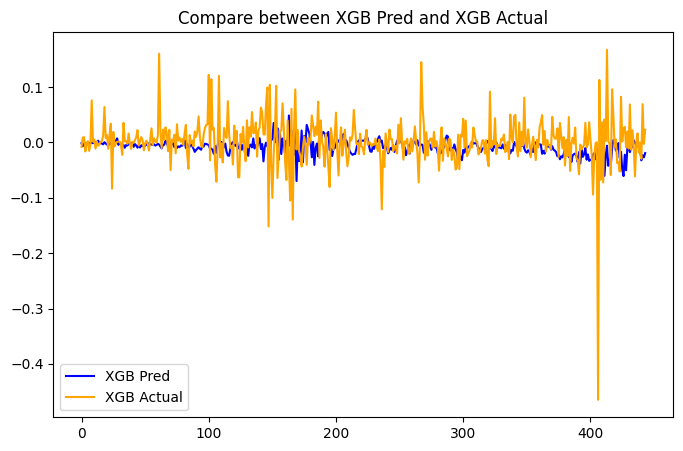

In [494]:
plt.figure(figsize=(8,5))
plt.plot(lr_preds, color = 'blue')
plt.plot(y_val.reset_index(drop=True), color = 'orange')
plt.title("Compare between XGB Pred and XGB Actual")
plt.legend(['XGB Pred', 'XGB Actual'])
save_plot_from_title()
plt.show()


#### Model_3 == RandomForest Regressor

In [454]:
rf = RandomForestRegressor(n_estimators=500, max_depth=10, min_samples_leaf=10, random_state=42, n_jobs=-1)
rf.fit(X_train_scaled, y_train_scaled.ravel())
rf_preds_scaled = rf.predict(X_val_scaled)
rf_preds = y_scaler.inverse_transform(rf_preds_scaled.reshape(-1,1)).flatten()


In [455]:
rf_rmse, rf_mae, rf_mape, rf_dir = evaluate_model(y_val.reset_index(drop=True), rf_preds)
rf_rmse, rf_mae, rf_mape, rf_dir


(0.042197788602156054,
 0.025374358038074914,
 152.97644103338118,
 0.49435665914221216)

Saved plot: D:/All_Projects/crypto-forecasting-project/reports/Compare_between_XGB_Pred_and_XGB_Actual.png


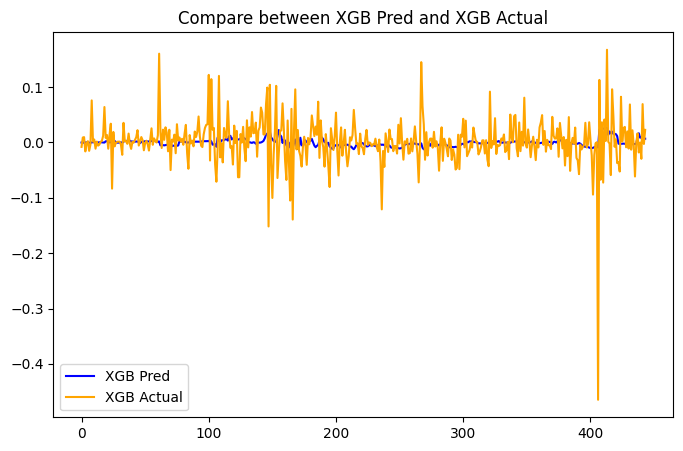

In [493]:
plt.figure(figsize=(8,5))
plt.plot(rf_preds, color = 'blue')
plt.plot(y_val.reset_index(drop=True), color = 'orange')
plt.title("Compare between XGB Pred and XGB Actual")
plt.legend(['XGB Pred', 'XGB Actual'])
save_plot_from_title()
plt.show()


In [456]:
# actuals, preds = walk_forward_validation(rf, X_train_scaled, y_train_scaled, train_size=int(len(X_train_scaled)*0.7))
# evaluate_model(pd.Series(actuals), preds)


#### Model_4 == XGBoost

In [469]:
xgb_model = XGBRegressor(n_estimators=500, 
                         max_depth=5, 
                         learning_rate=0.05, 
                         subsample=0.8, 
                         colsample_bytree=0.8,
                         objective='reg:squarederror', 
                         random_state=42, n_jobs=-1)


In [470]:
xgb_model.fit(X_train_scaled, y_train, eval_set=[(X_val_scaled, y_val)], verbose=False)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=-1, num_parallel_tree=None, ...)

In [477]:
xgb_preds = xgb_model.predict(X_val_scaled)


In [479]:
y_val.reset_index(drop=True)  


0     -0.008177
1      0.008682
2      0.009449
3     -0.016334
4     -0.001404
         ...   
439   -0.000381
440   -0.029713
441    0.069029
442   -0.002902
443    0.022501
Name: target, Length: 444, dtype: float64

In [472]:
xgb_rmse, xgb_mae, xgb_mape, xgb_dir = evaluate_model(y_val.reset_index(drop=True), xgb_preds)
xgb_rmse, xgb_mae, xgb_mape, xgb_dir



(0.0453042099148491, 0.02872663007104724, 272.415763260935, 0.5282167042889391)

In [473]:
# actuals, preds = walk_forward_validation(xgb_model, X_train.values, y_train.values, train_size=int(len(X_train)*0.7))
# evaluate_model(pd.Series(actuals), preds)


In [474]:
xgb_importance = pd.Series(xgb_model.feature_importances_, index=INPUT_FEATURES).sort_values(ascending=False)
xgb_importance.head(10)


Close_lag_6      0.037446
Close_lag_28     0.037444
Close_lag_26     0.035900
Close_lag_30     0.034218
Close_lag_25     0.032623
Close_lag_1      0.032333
Close_lag_3      0.031214
Close_lag_29     0.030422
Close_lag_13     0.028237
volatility_30    0.028123
dtype: float32

Saved plot: D:/All_Projects/crypto-forecasting-project/reports/XGBoost_Feature_Importance.png


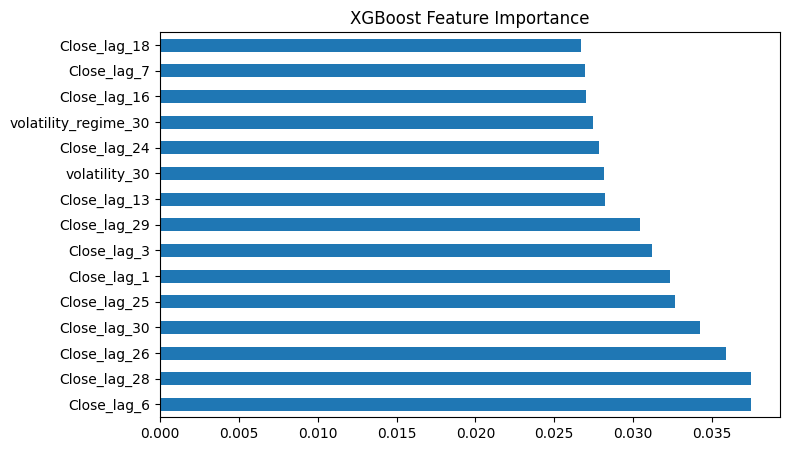

In [475]:
xgb_importance.head(15).plot(kind='barh', figsize=(8,5))
plt.title("XGBoost Feature Importance")
save_plot_from_title()
plt.show()


Saved plot: D:/All_Projects/crypto-forecasting-project/reports/Compare_between_XGB_Pred_and_XGB_Actual.png


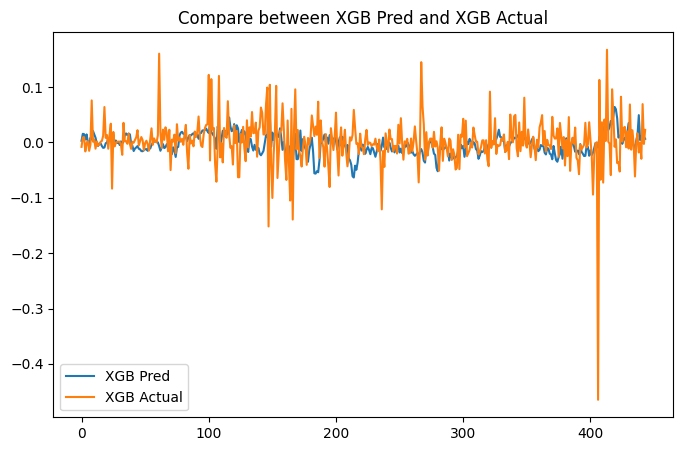

In [487]:
plt.figure(figsize=(8,5))
plt.plot(xgb_preds)
plt.plot(y_val.reset_index(drop=True))
plt.title("Compare between XGB Pred and XGB Actual")
plt.legend(['XGB Pred', 'XGB Actual'])
save_plot_from_title()
plt.show()


### Deep learning Models
#### LSTM
##### Sequence Window Creation

In [169]:
lstm_data = encoded_data[['Close', 'Volume', 'Marketcap', 'MA_7', 'MA_15', 'MA_30', 'volatility_7', 'volatility_15', 'volatility_30', 'volatility_regime_30']]
lstm_data['target_price'] = lstm_data['Close'].shift(-1)
lstm_data.head(3)


,Close,Volume,Marketcap,MA_7,MA_15,MA_30,volatility_7,volatility_15,volatility_30,volatility_regime_30,target_price
Date,,,,,,,,,,,
2013-04-29 23:59:59,144.539993,0.0,1.603769e+09,6690.163677,6661.91214,6606.573392,0.034614,0.036281,0.037536,0,139.000000
2013-04-30 23:59:59,139.000000,0.0,1.542813e+09,6690.163677,6661.91214,6606.573392,0.034614,0.036281,0.037536,0,116.989998
2013-05-01 23:59:59,116.989998,0.0,1.298955e+09,6690.163677,6661.91214,6606.573392,0.034614,0.036281,0.037536,0,105.209999


In [170]:
lstm_data.dropna(inplace=True)


In [171]:
LSTM_FEATURES = ['Close', 'Volume', 'Marketcap', 'MA_7', 'MA_15', 'MA_30', 'volatility_7', 'volatility_15', 'volatility_30', 'volatility_regime_30']
LSTM_TARGTE = 'target_price'


In [172]:
n = len(lstm_data)
train_end = int(0.70 * n)
val_end   = int(0.85 * n)


In [173]:
train_df = lstm_data.iloc[:train_end]
val_df   = lstm_data.iloc[train_end:val_end]
test_df  = lstm_data.iloc[val_end:]


In [174]:
X_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()


In [175]:
X_train = X_scaler.fit_transform(train_df[LSTM_FEATURES])
X_val   = X_scaler.transform(val_df[LSTM_FEATURES])
X_test  = X_scaler.transform(test_df[LSTM_FEATURES])

y_train = y_scaler.fit_transform(train_df[[LSTM_TARGTE]])
y_val   = y_scaler.transform(val_df[[LSTM_TARGTE]])
y_test  = y_scaler.transform(test_df[[LSTM_TARGTE]])


In [176]:
test_df


,Close,Volume,Marketcap,MA_7,MA_15,MA_30,volatility_7,volatility_15,volatility_30,volatility_regime_30,target_price
Date,,,,,,,,,,,
2020-04-13 23:59:59,6845.037697,3.861931e+10,1.254222e+11,7050.472584,6885.734730,6458.161113,0.027509,0.034997,0.050108,1,6842.427861
2020-04-14 23:59:59,6842.427861,3.411043e+10,1.253887e+11,7002.760207,6913.240459,6506.498212,0.027582,0.028685,0.049871,1,6642.109893
2020-04-15 23:59:59,6642.109893,3.228831e+10,1.217319e+11,6903.904698,6926.804800,6560.752543,0.025483,0.029993,0.048062,1,7116.804218
2020-04-16 23:59:59,7116.804218,4.678324e+10,1.304454e+11,6877.435371,6960.806664,6623.791710,0.040725,0.034216,0.048957,1,7096.184659
2020-04-17 23:59:59,7096.184659,3.251342e+10,1.300785e+11,6910.391269,6980.977335,6685.716580,0.031876,0.033661,0.048996,1,7257.664858
...,...,...,...,...,...,...,...,...,...,...,...
2021-07-01 23:59:59,33572.117653,3.783896e+10,6.293393e+11,33912.681466,34340.766891,35741.394627,0.054779,0.052022,0.051965,1,33897.048590
2021-07-02 23:59:59,33897.048590,3.872897e+10,6.354508e+11,34235.434114,34063.669852,35618.790261,0.039215,0.052242,0.051774,1,34668.548402
2021-07-03 23:59:59,34668.548402,2.438396e+10,6.499397e+11,34590.044219,33989.090093,35467.449674,0.039432,0.050547,0.051287,1,35287.779766


In [177]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape


((2093, 10), (2093, 1), (448, 10), (448, 1), (449, 10), (449, 1))

In [178]:
def create_sequences(X, y, window_size):
    X_seq, y_seq = [], []
    for i in range(window_size, len(X)):
        X_seq.append(X[i-window_size:i])
        y_seq.append(y[i])
    return np.array(X_seq), np.array(y_seq)


In [268]:
WINDOW_30 = 30
WINDOW_60 = 60
WINDOW_90 = 90

X_train_seq, y_train_seq = create_sequences(X_train, y_train, WINDOW_90)
X_val_seq, y_val_seq     = create_sequences(X_val, y_val, WINDOW_90)
X_test_seq, y_test_seq   = create_sequences(X_test, y_test, WINDOW_90)


#### LSTM Architecture

In [269]:
lstm_model = Sequential([LSTM(64, return_sequences=True, input_shape=(WINDOW_90, X_train_seq.shape[2])),
                         Dropout(0.2), LSTM(32),
                         Dropout(0.2),
                         Dense(1)])


In [270]:
lstm_model.compile(optimizer=Adam(learning_rate=0.0001), loss="mse")


In [271]:
lstm_model.summary()


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 90, 64)            19200     
                                                                 
 dropout_12 (Dropout)        (None, 90, 64)            0         
                                                                 
 lstm_9 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_13 (Dropout)        (None, 32)                0         
                                                                 
 dense_11 (Dense)            (None, 1)                 33        
                                                                 
Total params: 31,649
Trainable params: 31,649
Non-trainable params: 0
_________________________________________________________________


#### Training with EarlyStopping

In [273]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
early_stop


In [274]:
lstm_model.fit(X_train_seq, y_train_seq, 
               validation_data=(X_val_seq, y_val_seq), 
               epochs=100, 
               batch_size=32, 
               callbacks=[early_stop], 
               verbose=1)



Epoch 1/100
63/63 [==============================] - 6s 51ms/step - loss: 0.0176 - val_loss: 0.0073
Epoch 2/100
63/63 [==============================] - 3s 42ms/step - loss: 0.0054 - val_loss: 0.0037
Epoch 3/100
63/63 [==============================] - 3s 44ms/step - loss: 0.0047 - val_loss: 0.0030
Epoch 4/100
63/63 [==============================] - 4s 69ms/step - loss: 0.0039 - val_loss: 0.0029
Epoch 5/100
63/63 [==============================] - 4s 71ms/step - loss: 0.0032 - val_loss: 0.0028
Epoch 6/100
63/63 [==============================] - 4s 69ms/step - loss: 0.0033 - val_loss: 0.0036
Epoch 7/100
63/63 [==============================] - 4s 69ms/step - loss: 0.0031 - val_loss: 0.0025
Epoch 8/100
63/63 [==============================] - 4s 71ms/step - loss: 0.0026 - val_loss: 0.0025
Epoch 9/100
63/63 [==============================] - 4s 64ms/step - loss: 0.0025 - val_loss: 0.0028
Epoch 10/100
63/63 [==============================] - 4s 69ms/step - loss: 0.0023 - val_loss: 0.0023

In [496]:
lstm_val_preds_scaled = lstm_model.predict(X_val_seq, verbose=0)


Saved plot: D:/All_Projects/crypto-forecasting-project/reports/Compare_between_LSTM_Pred_and_LSTM_Actual.png


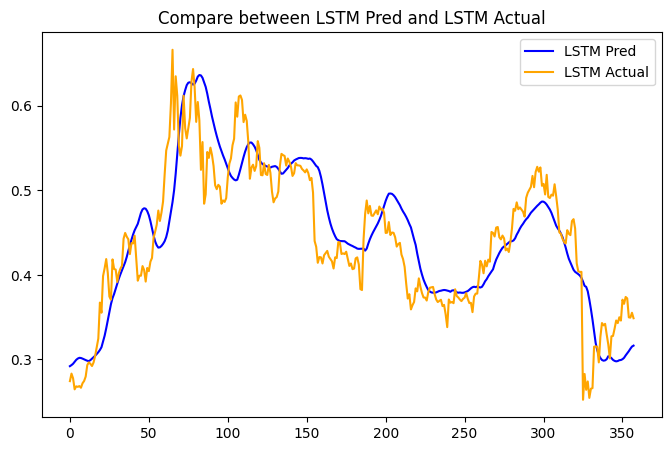

In [506]:
plt.figure(figsize=(8,5))
plt.plot(lstm_val_preds_scaled, color = 'blue')
plt.plot(y_val_seq, color = 'orange')
plt.title("Compare between LSTM Pred and LSTM Actual")
plt.legend(['LSTM Pred', 'LSTM Actual'])
save_plot_from_title()
plt.show()


#### LSTM Evaluation (Next-Day Prediction)

In [507]:
lstm_preds_scaled = lstm_model.predict(X_test_seq, verbose=0)


In [508]:
# Inverse scaling
lstm_pred = y_scaler.inverse_transform(lstm_preds_scaled.reshape(-1, 1)).flatten()
lstm_true = y_scaler.inverse_transform(y_test_seq.reshape(-1, 1)).flatten()


In [509]:
lstm_rmse, lstm_mae, lstm_mape, lstm_dir = evaluate_forecast(lstm_true, lstm_pred)
lstm_rmse, lstm_mae, lstm_mape, lstm_dir


(0.5342320296860341,
 0.37935168656471935,
 42.453556520737834,
 0.5307262569832403)

Saved plot: D:/All_Projects/crypto-forecasting-project/reports/Compare_between_LSTM_Pred_and_LSTM_Actual.png


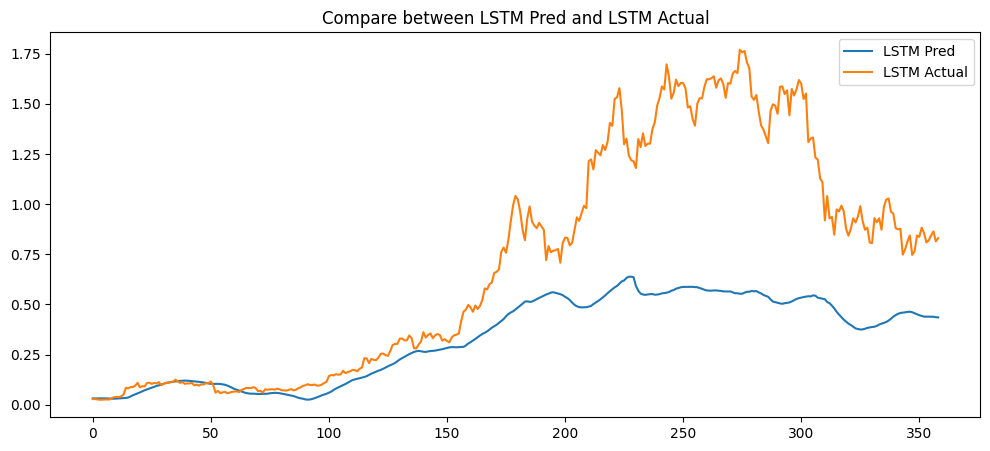

In [510]:
# lstm_preds = y_scaler.inverse_transform(lstm_pred).flatten()
# y_true = y_scaler.inverse_transform(lstm_true).flatten()
pd.DataFrame({'LSTM_Pred': lstm_pred, 'lstm_test': lstm_true})
plt.figure(figsize=(12,5))
plt.plot(lstm_pred)
plt.plot(lstm_true)
plt.title("Compare between LSTM Pred and LSTM Actual")
plt.legend(['LSTM Pred', 'LSTM Actual'])
save_plot_from_title()
plt.show()


In [511]:
lstm_model.save("../models/lstm_model.h5")


#### Multi-Step Forecasting (7 / 15 / 30 Days)

In [512]:
def multi_step_forecast(model, last_sequence, steps):
    preds = []
    seq = last_sequence.copy()
    for _ in range(steps):
        pred = model.predict(seq.reshape(1, *seq.shape), verbose=0)[0,0]
        preds.append(pred)
        seq = np.roll(seq, -1, axis=0)
        seq[-1, 0] = pred   # update Close feature
    return y_scaler.inverse_transform(np.array(preds).reshape(-1,1))


##### Generate Forecasts 

In [513]:
last_seq = X_test_seq[-1]

lstm_forecast_7  = multi_step_forecast(lstm_model, last_seq, 7)
lstm_forecast_15 = multi_step_forecast(lstm_model, last_seq, 15)
lstm_forecast_30 = multi_step_forecast(lstm_model, last_seq, 30)


Saved plot: D:/All_Projects/crypto-forecasting-project/reports/_7_15_30_-Day_Price_Forecast__LSTM_.png


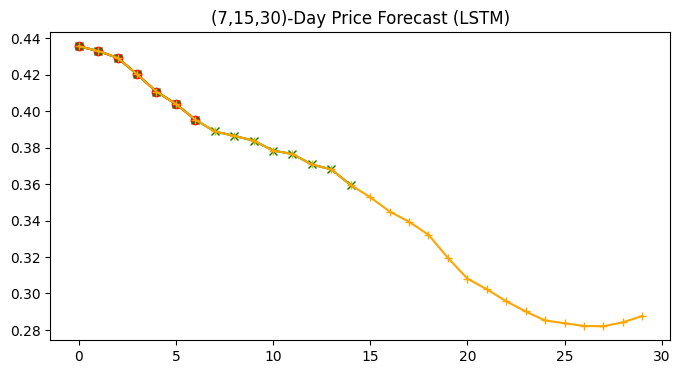

In [514]:
plt.figure(figsize=(8,4))
plt.plot(lstm_forecast_7, marker='o', color = 'red')
plt.plot(lstm_forecast_15, marker='x', color = 'green')
plt.plot(lstm_forecast_30, marker='+', color = 'orange')
plt.title("(7,15,30)-Day Price Forecast (LSTM)")
save_plot_from_title()
plt.show()   


### Build bonus models
like CNN-LSTM

In [515]:
cnn_lstm = Sequential([Conv1D(filters = 64, 
                              kernel_size=3, 
                              activation='relu', 
                              input_shape=(WINDOW_90, X_train_seq.shape[2])),
                       MaxPooling1D(2),
                       LSTM(64),
                       Dropout(0.3),
                       Dense(1)])



In [516]:
cnn_lstm.compile(optimizer=Adam(0.001), loss='mse')


In [517]:
cnn_lstm.summary()  


Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 88, 64)            1984      
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 44, 64)           0         
 1D)                                                             
                                                                 
 lstm_14 (LSTM)              (None, 64)                33024     
                                                                 
 dropout_21 (Dropout)        (None, 64)                0         
                                                                 
 dense_22 (Dense)            (None, 1)                 65        
                                                                 
Total params: 35,073
Trainable params: 35,073
Non-trainable params: 0
_________________________________________________

In [518]:
cnn_lstm.fit(X_train_seq, y_train_seq, validation_data=(X_val_seq, y_val_seq), epochs=50, batch_size=32, callbacks=[early_stop], verbose=1)


Epoch 1/50
63/63 [==============================] - 3s 21ms/step - loss: 0.0053 - val_loss: 0.0039
Epoch 2/50
63/63 [==============================] - 1s 14ms/step - loss: 0.0019 - val_loss: 0.0031
Epoch 3/50
63/63 [==============================] - 1s 14ms/step - loss: 0.0017 - val_loss: 0.0026
Epoch 4/50
63/63 [==============================] - 1s 14ms/step - loss: 0.0014 - val_loss: 0.0020
Epoch 5/50
63/63 [==============================] - 1s 15ms/step - loss: 0.0012 - val_loss: 0.0051
Epoch 6/50
63/63 [==============================] - 1s 14ms/step - loss: 0.0012 - val_loss: 0.0025
Epoch 7/50
63/63 [==============================] - 1s 15ms/step - loss: 0.0012 - val_loss: 0.0026
Epoch 8/50
63/63 [==============================] - 1s 14ms/step - loss: 0.0011 - val_loss: 0.0024
Epoch 9/50
63/63 [==============================] - 1s 14ms/step - loss: 8.8545e-04 - val_loss: 0.0013
Epoch 10/50
63/63 [==============================] - 1s 19ms/step - loss: 9.9886e-04 - val_loss: 0.0016
E

In [520]:
cnn_lstm_preds = cnn_lstm.predict(X_test_seq, verbose=0)
cnn_lstm_preds = y_scaler.inverse_transform(cnn_lstm_preds).flatten()

cnn_lstm_rmse, cnn_lstm_mae, cnn_lstm_mape, cnn_lstm_dir = evaluate_forecast(y_test_seq, cnn_lstm_preds)
cnn_lstm_rmse, cnn_lstm_mae, cnn_lstm_mape, cnn_lstm_dir


(1.1107995976848402, 0.9967631596435341, 68.89020848025619, 0.5078961330794919)

Saved plot: D:/All_Projects/crypto-forecasting-project/reports/Compare_between_CNN-LSTM_Pred_and_CNN-LSTM_Actual.png


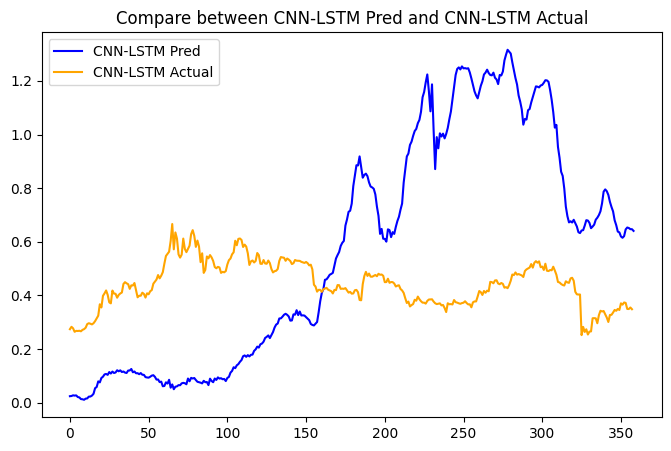

In [522]:
plt.figure(figsize=(8,5))
plt.plot(cnn_lstm_preds, color = 'blue')
plt.plot(y_val_seq, color = 'orange')
plt.title("Compare between CNN-LSTM Pred and CNN-LSTM Actual")
plt.legend(['CNN-LSTM Pred', 'CNN-LSTM Actual'])
save_plot_from_title()
plt.show()


##### Next 7, 15, 30 days forecast

Saved plot: D:/All_Projects/crypto-forecasting-project/reports/_7_15_30_-Day_Price_Forecast__CNN-LSTM_.png


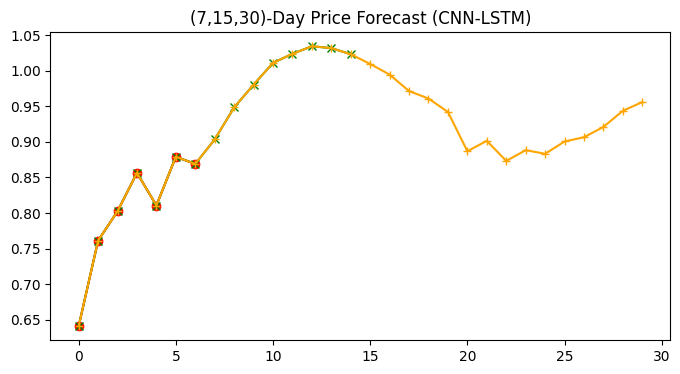

In [524]:
cnn_forecast_7  = multi_step_forecast(cnn_lstm, last_seq, 7)
cnn_forecast_15 = multi_step_forecast(cnn_lstm, last_seq, 15)
cnn_forecast_30 = multi_step_forecast(cnn_lstm, last_seq, 30)

plt.figure(figsize=(8,4))
plt.plot(cnn_forecast_7, marker='o', color = 'red')
plt.plot(cnn_forecast_15, marker='x', color = 'green')
plt.plot(cnn_forecast_30, marker='+', color = 'orange')
plt.title("(7,15,30)-Day Price Forecast (CNN-LSTM)")
save_plot_from_title()
plt.show()


In [525]:
cnn_lstm.save("../models/cnn_lstm_model.h5")


Attention Based Models
- Simple Attention Mechanism

In [526]:
inputs = Input(shape=(WINDOW_90, X_train_seq.shape[2]))
x = LSTM(64, return_sequences=True)(inputs)
attn = Attention()([x, x])
x = GlobalAveragePooling1D()(attn)
outputs = Dense(1)(x)
attn_model = Model(inputs, outputs)


In [527]:
attn_model.compile(optimizer=Adam(0.001), loss='mse')


In [528]:
attn_model.fit(X_train_seq, y_train_seq, validation_data=(X_val_seq, y_val_seq), epochs=50, batch_size=32, callbacks=[early_stop], verbose=1)


Epoch 1/50
63/63 [==============================] - 5s 56ms/step - loss: 0.0063 - val_loss: 0.0077
Epoch 2/50
63/63 [==============================] - 3s 55ms/step - loss: 0.0050 - val_loss: 0.0072
Epoch 3/50
63/63 [==============================] - 3s 48ms/step - loss: 0.0043 - val_loss: 0.0295
Epoch 4/50
63/63 [==============================] - 3s 49ms/step - loss: 0.0026 - val_loss: 0.1292
Epoch 5/50
63/63 [==============================] - 4s 59ms/step - loss: 0.0021 - val_loss: 0.0883
Epoch 6/50
63/63 [==============================] - 4s 62ms/step - loss: 0.0021 - val_loss: 0.0510
Epoch 7/50
63/63 [==============================] - 4s 64ms/step - loss: 0.0019 - val_loss: 0.0591
Epoch 8/50
63/63 [==============================] - 4s 60ms/step - loss: 0.0014 - val_loss: 0.0892
Epoch 9/50
63/63 [==============================] - 3s 52ms/step - loss: 0.0017 - val_loss: 0.0766
Epoch 10/50
63/63 [==============================] - 2s 38ms/step - loss: 0.0016 - val_loss: 0.0930
Epoch 11/

In [529]:
att_preds = attn_model.predict(X_test_seq, verbose=0)
att_preds = y_scaler.inverse_transform(att_preds).flatten()

att_rmse, att_mae, att_mape, att_dir = evaluate_forecast(y_test_seq, att_preds)
att_rmse, att_mae, att_mape, att_dir


(1.5689385355844696, 1.3659852278791442, 81.02348736582164, 0.521285228301239)

Saved plot: D:/All_Projects/crypto-forecasting-project/reports/Compare_between_Attention_Pred_and_Attention_Actual.png


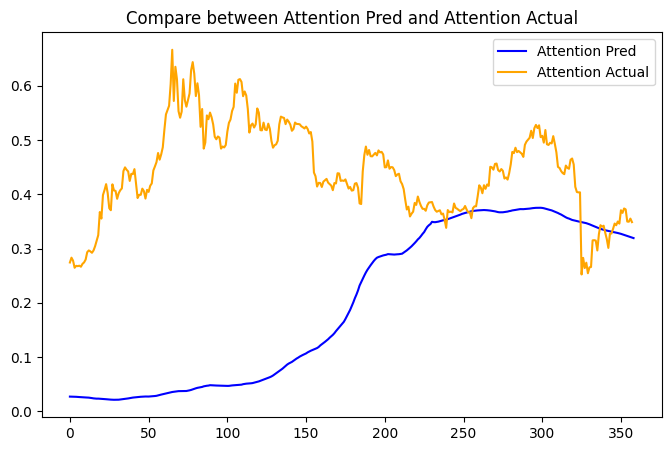

In [531]:
plt.figure(figsize=(8,5))
plt.plot(att_preds, color = 'blue')
plt.plot(y_val_seq, color = 'orange')
plt.title("Compare between Attention Pred and Attention Actual")
plt.legend(['Attention Pred', 'Attention Actual'])
save_plot_from_title()
plt.show()


Saved plot: D:/All_Projects/crypto-forecasting-project/reports/_7_15_30_-Day_Price_Forecast__Attention-based_Model_.png


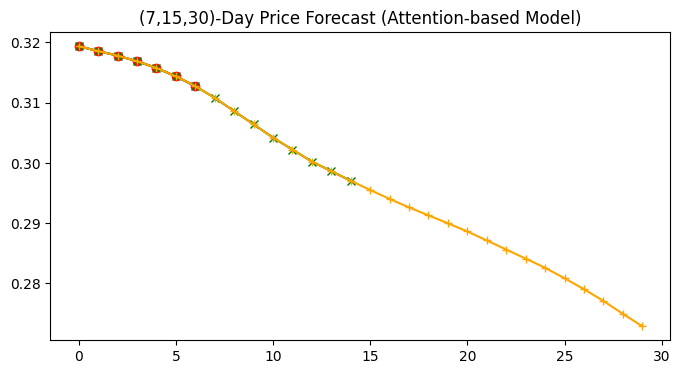

In [532]:
attn_forecast_7  = multi_step_forecast(attn_model, last_seq, 7)
attn_forecast_15 = multi_step_forecast(attn_model, last_seq, 15)
attn_forecast_30 = multi_step_forecast(attn_model, last_seq, 30)
plt.figure(figsize=(8,4))
plt.plot(attn_forecast_7, marker='o', color = 'red')
plt.plot(attn_forecast_15, marker='x', color = 'green')
plt.plot(attn_forecast_30, marker='+', color = 'orange')
plt.title("(7,15,30)-Day Price Forecast (Attention-based Model)")
save_plot_from_title()
plt.show()





In [533]:
attn_model.save("../models/attention_model.h5")


##### Transformer Time-Series Model

In [534]:
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, seq_len, d_model):
        super().__init__()
        pos = np.arange(seq_len)[:, np.newaxis]
        i = np.arange(d_model)[np.newaxis, :]
        angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
        angle_rads = pos * angle_rates
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
        self.pos_encoding = tf.constant(angle_rads[np.newaxis, ...], dtype=tf.float32)

    def call(self, x):
        return x + self.pos_encoding[:, :tf.shape(x)[1], :]


In [535]:
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = Sequential([
            Dense(ff_dim, activation="relu"),
            Dense(embed_dim),])
        self.layernorm1 = LayerNormalization()
        self.layernorm2 = LayerNormalization()
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


In [ ]:
embed_dim = X_train_seq.shape[2]
num_heads = 4
ff_dim = 128

inputs = tf.keras.Input(shape=(WINDOW_60, embed_dim))
x = PositionalEncoding(WINDOW_60, embed_dim)(inputs)

x = TransformerBlock(embed_dim, num_heads, ff_dim)(x)
x = TransformerBlock(embed_dim, num_heads, ff_dim)(x)

x = tf.keras.layers.GlobalAveragePooling1D()(x)
x = Dense(64, activation="relu")(x)
x = Dropout(0.3)(x)
outputs = Dense(1)(x)


In [537]:
transformer_model = tf.keras.Model(inputs, outputs)


In [538]:
transformer_model.compile(optimizer=Adam(learning_rate=0.001), loss="mse")


In [539]:
transformer_model.summary()


Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 90, 10)]          0         
                                                                 
 positional_encoding_2 (Posi  (None, 90, 10)           0         
 tionalEncoding)                                                 
                                                                 
 transformer_block_4 (Transf  (None, 90, 10)           4468      
 ormerBlock)                                                     
                                                                 
 transformer_block_5 (Transf  (None, 90, 10)           4468      
 ormerBlock)                                                     
                                                                 
 global_average_pooling1d_6   (None, 10)               0         
 (GlobalAveragePooling1D)                                  

In [540]:
transformer_model.fit(X_train_seq, y_train_seq,
                                      validation_data=(X_val_seq, y_val_seq),
                                      epochs=50,
                                      batch_size=32,
                                      callbacks=[early_stop],
                                      verbose=1)


Epoch 1/50
63/63 [==============================] - 6s 56ms/step - loss: 0.0950 - val_loss: 0.0587
Epoch 2/50
63/63 [==============================] - 4s 66ms/step - loss: 0.0169 - val_loss: 0.0466
Epoch 3/50
63/63 [==============================] - 4s 69ms/step - loss: 0.0099 - val_loss: 0.0749
Epoch 4/50
63/63 [==============================] - 3s 48ms/step - loss: 0.0071 - val_loss: 0.0657
Epoch 5/50
63/63 [==============================] - 3s 53ms/step - loss: 0.0061 - val_loss: 0.1219
Epoch 6/50
63/63 [==============================] - 4s 62ms/step - loss: 0.0054 - val_loss: 0.0973
Epoch 7/50
63/63 [==============================] - 3s 55ms/step - loss: 0.0045 - val_loss: 0.1486
Epoch 8/50
63/63 [==============================] - 4s 63ms/step - loss: 0.0039 - val_loss: 0.0998
Epoch 9/50
63/63 [==============================] - 4s 66ms/step - loss: 0.0032 - val_loss: 0.1412
Epoch 10/50
63/63 [==============================] - 4s 64ms/step - loss: 0.0027 - val_loss: 0.1248
Epoch 11/

In [542]:
trans_preds = transformer_model.predict(X_test_seq, verbose=0)
trans_preds = y_scaler.inverse_transform(trans_preds).flatten()

trans_rmse, trans_mae, trans_mape, trans_dir = evaluate_forecast(y_test_seq, trans_preds)
trans_rmse, trans_mae, trans_mape, trans_dir


(1.8293868709994623, 1.604154851437007, 103.86028896452284, 0.5116725445522924)

Saved plot: D:/All_Projects/crypto-forecasting-project/reports/Compare_between_Transformer_Pred_and_Transformer_Actual.png


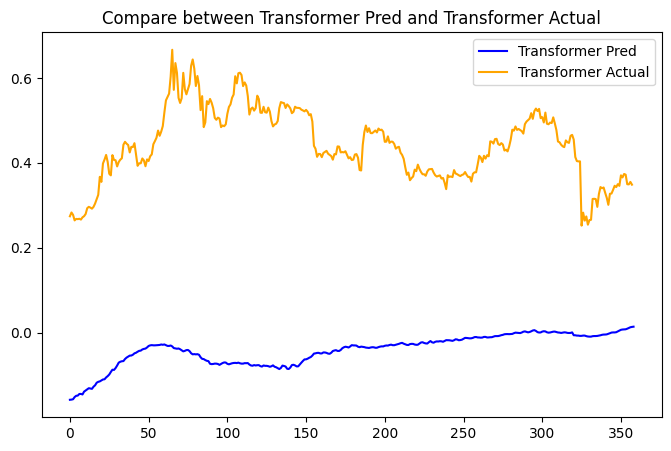

In [543]:
plt.figure(figsize=(8,5))
plt.plot(trans_preds, color = 'blue')
plt.plot(y_val_seq, color = 'orange')
plt.title("Compare between Transformer Pred and Transformer Actual")
plt.legend(['Transformer Pred', 'Transformer Actual'])
save_plot_from_title()
plt.show()


In [544]:
trans_forecast_7  = multi_step_forecast(transformer_model, last_seq, 7)
trans_forecast_15 = multi_step_forecast(transformer_model, last_seq, 15)
trans_forecast_30 = multi_step_forecast(transformer_model, last_seq, 30)


Saved plot: D:/All_Projects/crypto-forecasting-project/reports/_7_15_30_-Day_Price_Forecast__Transformer_.png


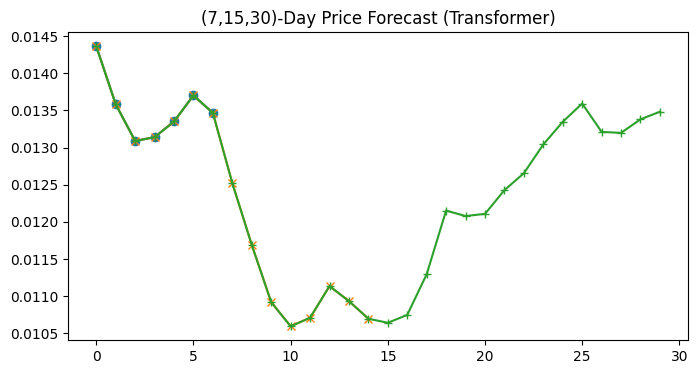

In [545]:
plt.figure(figsize=(8,4))
plt.plot(trans_forecast_7, marker='o')
plt.plot(trans_forecast_15, marker='x')
plt.plot(trans_forecast_30, marker='+')
plt.title("(7,15,30)-Day Price Forecast (Transformer)")
save_plot_from_title()
plt.show()


In [546]:
transformer_model.save("../models/transformer_model.h5")


#### Model Comparision Table

In [547]:
dl_results = pd.DataFrame({'Model': ['ARIMA', 'Linear Regression', 'Random Forest', 'XGBoost', 'LSTM', 'CNN-LSTM', 'Attention-LSTM', 'Transformer'],
                           'RMSE': [arima_rmse, lr_rmse, rf_rmse, xgb_rmse, lstm_rmse, cnn_lstm_rmse, att_rmse, trans_rmse],
                           'MAE': [arima_mae, lr_mae, rf_mae, xgb_mae, lstm_mae, cnn_lstm_mae, att_mae, trans_mae],
                           'MAPE (%)': [arima_mape, lr_mape, rf_mape, xgb_mape, lstm_mape, cnn_lstm_mape, att_mape, trans_mape],
                           'Directional Accuracy': [arima_dir, lr_dir, rf_dir, xgb_dir, lstm_dir, cnn_lstm_dir, att_dir, trans_dir]})
dl_results


,Model,RMSE,MAE,MAPE (%),Directional Accuracy
0,ARIMA,0.042584,0.025167,NaN,0.045147
1,Linear Regression,0.045637,0.029228,283.989087,0.512415
2,Random Forest,0.042198,0.025374,152.976441,0.494357
3,XGBoost,0.045304,0.028727,272.415763,0.528217
4,LSTM,0.534232,0.379352,42.453557,0.530726
5,CNN-LSTM,1.110800,0.996763,68.890208,0.507896
6,Attention-LSTM,1.568939,1.365985,81.023487,0.521285
7,Transformer,1.829387,1.604155,103.860289,0.511673


#### Multi step forecasting

In [332]:
def multi_step_forecast_xgb(model, last_row, steps):
    """
    last_row: last known feature row (1D numpy array)
    steps: forecast horizon
    """
    preds = []
    current_input = last_row.copy()
    for _ in range(steps):
        pred = model.predict(current_input.reshape(1, -1))[0]
        preds.append(pred)
        # shift lag features
        current_input[1:] = current_input[:-1]
        current_input[0] = pred  # update Close_lag_1 or return-based feature
    return np.array(preds)


In [333]:
last_X = X_test_scaled[-1]
forecast_7  = multi_step_forecast_xgb(xgb_model, last_X, 7)
forecast_15 = multi_step_forecast_xgb(xgb_model, last_X, 15)
forecast_30 = multi_step_forecast_xgb(xgb_model, last_X, 30)


Saved plot: D:/All_Projects/crypto-forecasting-project/reports/Actual_vs_Predicted__30-Day_Forecast_XGBoost_.png


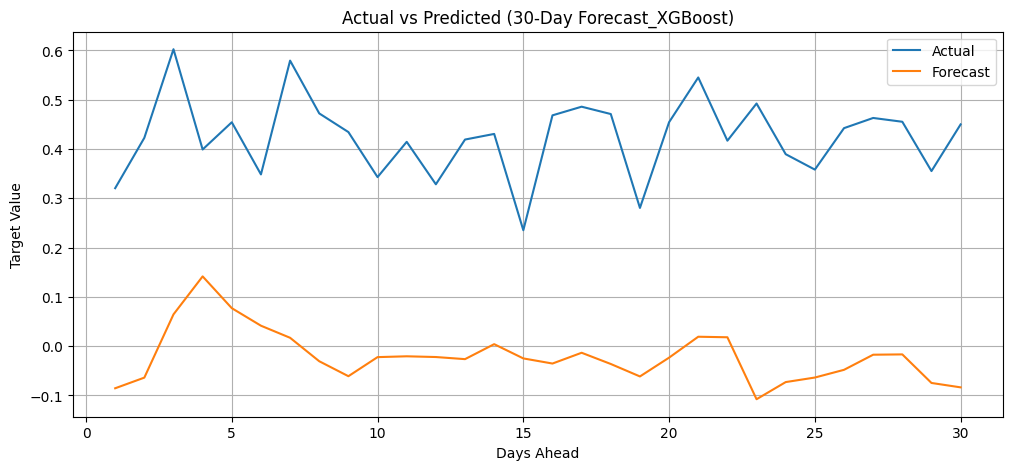

In [551]:
days = np.arange(1, 31)
plt.figure(figsize=(12,5))
plt.plot(days, y_test_scaled[-30:], label='Actual')
plt.plot(days, forecast_30, label='Forecast')
plt.title("Actual vs Predicted (30-Day Forecast_XGBoost)")
plt.xlabel("Days Ahead")
plt.ylabel("Target Value")
plt.legend()
plt.grid(True)
save_plot_from_title()
plt.show()



In [552]:
errors = y_test[-30:] - forecast_30


Saved plot: D:/All_Projects/crypto-forecasting-project/reports/Forecast_Error_Distribution__30-Day_.png


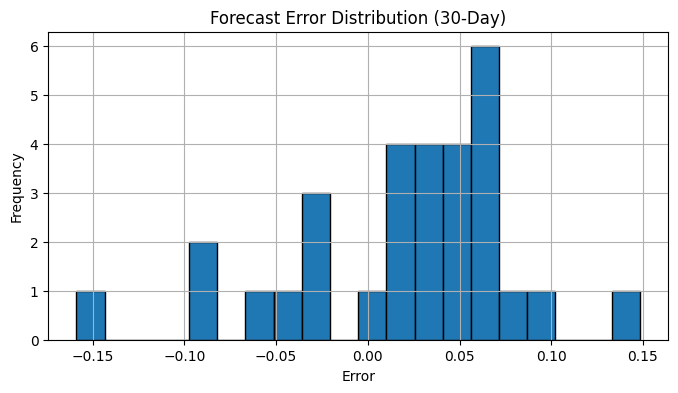

In [555]:
plt.figure(figsize=(8,4))
plt.hist(errors, bins=20, edgecolor='black')
plt.title("Forecast Error Distribution (30-Day)")
plt.xlabel("Error")
plt.ylabel("Frequency")
plt.grid(True)
save_plot_from_title()
plt.show()


In [556]:
len(y_test)
# len(xgb_model.predict(X_test_scaled))



444

In [557]:
residuals = y_test - xgb_model.predict(X_test_scaled)
sigma = np.std(residuals)


In [558]:
upper = forecast_30 + 1.96 * sigma
lower = forecast_30 - 1.96 * sigma


Saved plot: D:/All_Projects/crypto-forecasting-project/reports/30-Day_Forecast_with_Confidence_Interval.png


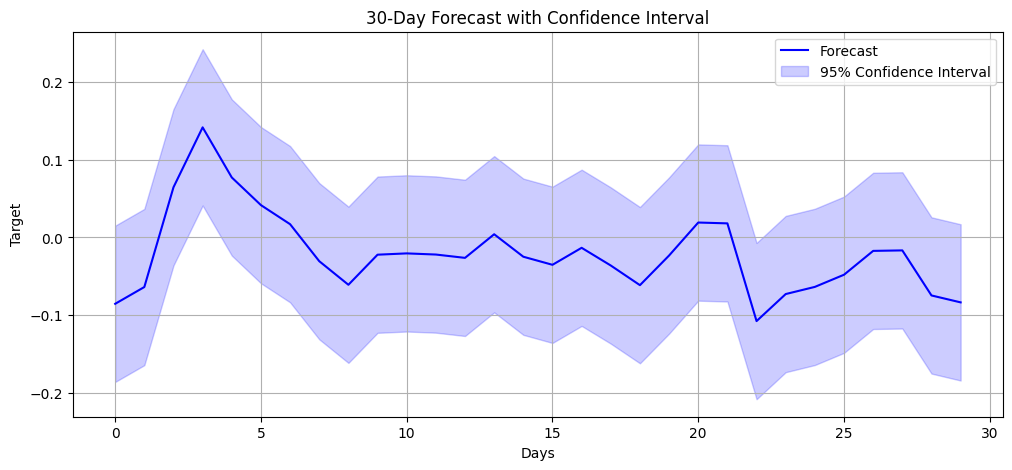

In [560]:
plt.figure(figsize=(12,5))
plt.plot(forecast_30, label='Forecast', color='blue')
plt.fill_between(range(len(forecast_30)), lower, upper, color='blue', alpha=0.2, label='95% Confidence Interval')
plt.title("30-Day Forecast with Confidence Interval")
plt.xlabel("Days")
plt.ylabel("Target")
plt.legend()
plt.grid(True)
save_plot_from_title()
plt.show()
